In [3]:
!git clone https://github.com/Jithin06/PolarNet.git

Cloning into 'PolarNet'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 306.91 KiB | 5.68 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [4]:
cd PolarNet/

/content/PolarNet


In [5]:
pwd

'/content/PolarNet'

In [6]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.autonotebook import tqdm
from polar import PolarCode, get_frozen
from reliability_sequence import Reliability_Sequence
from utils import errors_ber, errors_bler
import matplotlib.pyplot as plt
import random
import os

<ipython-input-6-a4b06a8efe2d>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
n = 5
N = 2**n
K = 16
snr = 2
batch_size = 64
num_samples = 20000
seed = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(seed)

In [9]:
def create_data(num_samples, n, K, snr,rs):
    """
    Parameters:
    - num_samples: Total number of samples to generate
    - batch_size: Batch size for data generation
    - n: Polar code parameter
    - K: Information bit length
    - snr: Signal-to-Noise Ratio
    - rs: Reliability Sequence

    Returns:
    - Saved .npz file with dataset
    """

    msg_bits_list = []
    bpsk_list = []
    codeword_list = []
    corrupted_codeword_list = []

    polar = PolarCode(n, K, rs = rs, use_cuda=False,hard_decision=True)
    # Loop to generate data samples
    for i in range(num_samples):
        msg_bits = (torch.rand(K) > 0.5).float()
        bpsk = 1 - 2 * msg_bits

        codeword = polar.encode(bpsk.unsqueeze(0)).squeeze(0)
        corrupted_codewords = polar.channel(codeword.unsqueeze(0), snr).squeeze(0)

        msg_bits_list.append(msg_bits.cpu().numpy())
        bpsk_list.append(bpsk.cpu().numpy())
        codeword_list.append(codeword.cpu().numpy())
        corrupted_codeword_list.append(corrupted_codewords.cpu().numpy())

        msg_bits_array = np.stack(msg_bits_list)
        bpsk_array = np.stack(bpsk_list)
        codeword_array = np.stack(codeword_list)
        corrupted_codeword_array = np.stack(corrupted_codeword_list)

    filename = f"polar_dataset_N{2**n}_K{K}_SNR{snr}_samples{num_samples}.npz"
    np.savez(filename, msg_bits=msg_bits_array, corrupted_codeword=corrupted_codeword_array, bpsk=bpsk_array, codeword=codeword_array)
    print(f"Dataset saved as {filename}")

In [10]:
create_data(num_samples,n,K,snr,rs=Reliability_Sequence)

Dataset saved as polar_dataset_N32_K16_SNR2_samples20000.npz


In [11]:
class PolarDatasetWithLLRMatrix:
    def __init__(self, data_path, n, K, snr, save_decoded_path=None):
        """
        Dataset that processes polar codes and stores both decoded bits and LLR matrices

        Args:
            data_path (str): Path to the original data file (.npz)
            n (int): Log2 of codeword length (N = 2^n)
            K (int): Information length
            snr (float): Signal-to-noise ratio in dB
            save_decoded_path (str, optional): Path to save the decoded bits for future use
        """
        self.n = n
        self.N = 2**n
        self.K = K
        self.snr = snr

        # Load the original data
        print(f"Loading data from {data_path}")
        data = np.load(data_path)

        # Create polar code object
        self.polar = PolarCode(n, K, rs=Reliability_Sequence, Fr=None, use_cuda=torch.cuda.is_available(), hard_decision=True)

        # Store the data
        self.msg_bits = torch.tensor(data['msg_bits'])
        self.bpsk = torch.tensor(data['bpsk'])
        self.corrupted_codeword = torch.tensor(data['corrupted_codeword'])
        self.codeword = torch.tensor(data['codeword'])

        # Generate decoded bits and LLR matrices in a single pass
        self.decoded_bits = []
        self.llr_matrices = []
        print("Generating decoded bits and LLR matrices for all samples...")

        # First, make a test call to check the number of return values
        test_batch = self.corrupted_codeword[:1]  # Just use the first sample
        device = torch.device('cuda' if torch.cuda.is_available() and hasattr(self.polar, 'device') and self.polar.device.type == 'cuda' else 'cpu')
        test_batch = test_batch.to(device)

        # Try to call sc_decode_new and see what it returns
        try:
            result = self.polar.sc_decode_new(test_batch, snr=self.snr)
            num_returns = len(result) if isinstance(result, tuple) else 1
            print(f"sc_decode_new returns {num_returns} values")

            # Modify our approach based on the return values
            if num_returns == 2:
                # If only 2 returns (likely final_llrs and decoded_bits)
                print("Detected 2-value return pattern - will modify LLR matrix collection")
                collect_llr_matrix_separately = True
            else:
                # Assuming 3 returns as expected
                collect_llr_matrix_separately = False

        except Exception as e:
            print(f"Error during test call: {e}")
            # Default to separate collection if test fails
            collect_llr_matrix_separately = True

        # Process in batches to avoid memory issues
        batch_size = 100
        num_batches = len(self.msg_bits) // batch_size + (0 if len(self.msg_bits) % batch_size == 0 else 1)

        for i in tqdm(range(num_batches)):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(self.msg_bits))

            corrupted_batch = self.corrupted_codeword[start_idx:end_idx]
            # Move to appropriate device
            corrupted_batch = corrupted_batch.to(device)

            if collect_llr_matrix_separately:
                try:
                    # Try with return_llr_matrix parameter
                    final_llrs, batch_decoded_bits = self.polar.sc_decode_new(corrupted_batch, snr=self.snr, return_llr_matrix=False)
                except TypeError:
                    # Fall back if parameter doesn't exist
                    final_llrs, batch_decoded_bits = self.polar.sc_decode_new(corrupted_batch, snr=self.snr)

                # Need to define a method to collect LLR matrices separately
                llr_matrix_batch = self._collect_llr_matrices(corrupted_batch, snr=self.snr)
            else:
                try:
                    # Try with return_llr_matrix parameter
                    final_llrs, batch_decoded_bits, llr_matrix_batch = self.polar.sc_decode_new(corrupted_batch, snr=self.snr, return_llr_matrix=True)
                except TypeError:
                    # Fall back if parameter doesn't exist
                    final_llrs, batch_decoded_bits, llr_matrix_batch = self.polar.sc_decode_new(corrupted_batch, snr=self.snr)
                # Debug: check if LLR matrix contains non-zero values
                if torch.all(llr_matrix_batch == 0):
                    print("WARNING: LLR matrix contains all zeros!")
                    print(f"LLR matrix shape: {llr_matrix_batch.shape}")
                    # Try to print some values from final_llrs to confirm LLRs are calculated
                    print(f"Sample final LLRs: {final_llrs[0, :10]}")  # Print first 10 values

            # Store results
            self.decoded_bits.append(batch_decoded_bits.cpu().numpy())
            self.llr_matrices.append(llr_matrix_batch.cpu().numpy())

        # Concatenate batches
        self.decoded_bits = np.concatenate(self.decoded_bits, axis=0)
        self.llr_matrices = np.concatenate(self.llr_matrices, axis=0)

        print(f"Decoded bits shape: {self.decoded_bits.shape}")
        print(f"LLR matrices shape: {self.llr_matrices.shape}")

        # Save the decoded bits for future use if path is provided
        if save_decoded_path:
            print(f"Saving decoded bits to {save_decoded_path}")
            np.savez(
                save_decoded_path,
                decoded_bits=self.decoded_bits,
                info_positions=self.polar.info_positions
            )

        # Calculate and print BER and BLER
        decoded_bits_tensor = torch.tensor(self.decoded_bits)
        ber = errors_ber(self.msg_bits, decoded_bits_tensor).item()
        bler = errors_bler(self.msg_bits, decoded_bits_tensor).item()
        print(f"SC Decoder Performance - BER: {ber:.6f}, BLER: {bler:.6f}")

    def _collect_llr_matrices(self, corrupted_batch, snr):
        """
        Method to separately collect LLR matrices during decoding.
        This needs to be implemented based on how your polar code operates.
        """
        # Since this is highly dependent on the PolarCode implementation,
        # we need to modify the PolarCode class to expose the LLR matrices
        # For now, creating a placeholder matrix of correct size
        batch_size = corrupted_batch.shape[0]
        llr_matrix = torch.zeros((batch_size, self.n+1, self.N), device=corrupted_batch.device)

        # This is where we would collect the actual LLR matrices
        # This may require modifying the PolarCode class

        return llr_matrix

    def __len__(self):
        return len(self.msg_bits)

    def __getitem__(self, idx):
        return {
            'msg_bits': self.msg_bits[idx],
            'bpsk': self.bpsk[idx],
            'corrupted_codeword': self.corrupted_codeword[idx],
            'codeword': self.codeword[idx],
            'decoded_bits': torch.tensor(self.decoded_bits[idx], dtype=torch.float32),
            'llr_matrix': torch.tensor(self.llr_matrices[idx], dtype=torch.float32)
        }

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolarLLRMatrixNet(nn.Module):
    def __init__(self, n, K, hidden_channels=64):
        super().__init__()
        self.n = n
        self.N = 2**n
        self.K = K

        # CNN layers
        self.conv1 = nn.Conv2d(1, hidden_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_channels)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_channels*2)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute output size after conv layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, n + 1, self.N)  # Shape: [B, C, H, W]
            x = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
            x = F.relu(self.bn2(self.conv2(x)))
            self.flattened_size = x.view(1, -1).shape[1]

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, hidden_channels*4)
        self.fc2 = nn.Linear(hidden_channels*4, hidden_channels*2)
        self.fc3 = nn.Linear(hidden_channels*2, K)

        # Regularization
        self.dropout = nn.Dropout(0.2)
        self.act = nn.ReLU()

    def forward(self, x):
        # Input: [B, n+1, N]
        x = x.unsqueeze(1)  # [B, 1, n+1, N]
        x = self.act(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.act(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [13]:
import os
import torch
import csv
from tqdm import tqdm

def train_llr_matrix_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,
                           patience=20, n=5, K=16, snr=1.0, log_dir="training_logs"):
    best_val_loss = float('inf')
    trigger_times = 0

    train_loss_values = []
    train_ber_values = []
    train_bler_values = []
    val_loss_values = []
    val_ber_values = []
    val_bler_values = []

    # Logging setup
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(log_dir, f'train_log_N_{2**n}_K_{K}_SNR_{snr}.csv')
    with open(log_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Train BER', 'Val BER', 'Train BLER', 'Val BLER'])

    for epoch in range(num_epochs):
        model.train()
        train_total_loss, train_total_ber, train_total_bler = 0, 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False):
            msg_bits = batch['msg_bits'].to(device)
            llr_matrix = batch['llr_matrix'].to(device)

            optimizer.zero_grad()
            outputs = model(llr_matrix)
            loss = criterion(outputs, msg_bits)
            loss.backward()
            optimizer.step()

            predicted_bits = torch.round(torch.sigmoid(outputs))
            ber, bler = calculate_ber_bler(msg_bits, predicted_bits)

            train_total_loss += loss.item()
            train_total_ber += ber
            train_total_bler += bler

        train_avg_loss = train_total_loss / len(train_loader)
        train_avg_ber = train_total_ber / len(train_loader)
        train_avg_bler = train_total_bler / len(train_loader)

        train_loss_values.append(train_avg_loss)
        train_ber_values.append(train_avg_ber)
        train_bler_values.append(train_avg_bler)

        model.eval()
        val_total_loss, val_total_ber, val_total_bler = 0, 0, 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False):
                msg_bits = batch['msg_bits'].to(device)
                llr_matrix = batch['llr_matrix'].to(device)

                outputs = model(llr_matrix)
                loss = criterion(outputs, msg_bits)

                predicted_bits = torch.round(torch.sigmoid(outputs))
                ber, bler = calculate_ber_bler(msg_bits, predicted_bits)

                val_total_loss += loss.item()
                val_total_ber += ber
                val_total_bler += bler

        val_avg_loss = val_total_loss / len(val_loader)
        val_avg_ber = val_total_ber / len(val_loader)
        val_avg_bler = val_total_bler / len(val_loader)

        val_loss_values.append(val_avg_loss)
        val_ber_values.append(val_avg_ber)
        val_bler_values.append(val_avg_bler)

        # Save to log file
        with open(log_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch + 1, train_avg_loss, val_avg_loss, train_avg_ber, val_avg_ber, train_avg_bler, val_avg_bler])

        # Save best model
        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            trigger_times = 0

            save_dir = f'weights_llr_matrix/N_{2**n}_K_{K}_SNR_{snr}_hidden_{model.fc1.in_features}'
            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir, f'epoch_{epoch + 1}.pth'))
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"⏹️ Early stopping at epoch {epoch + 1}!")
                break

        # Print progress every epoch
        if ((epoch+1)%5==0):
            print(f"[Epoch {epoch+1}] Train Loss: {train_avg_loss:.4f}, Val Loss: {val_avg_loss:.4f}")
            print(f"              Train BER: {train_avg_ber:.4f}, Val BER: {val_avg_ber:.4f}")
            print(f"              Train BLER: {train_avg_bler:.4f}, Val BLER: {val_avg_bler:.4f}")

    print(f'✅ Training complete. Best val loss: {best_val_loss:.4f} at epoch {epoch + 1 - trigger_times}')
    print(f"📁 Logs saved to: {log_path}")
    return train_loss_values, train_ber_values, train_bler_values, val_loss_values, val_ber_values, val_bler_values

In [14]:
# Utility function for calculating BER and BLER
def calculate_ber_bler(targets, predictions):
    ber = errors_ber(targets, predictions).item()
    bler = errors_bler(targets, predictions).item()
    return ber, bler

# Function to visualize the LLR matrix
def visualize_llr_matrix(llr_matrix, title="LLR Matrix"):
    plt.figure(figsize=(12, 8))
    plt.imshow(llr_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='LLR Value')
    plt.title(title)
    plt.xlabel('N (Codeword Length)')
    plt.ylabel('Decoding Stage (log2N + 1)')
    plt.tight_layout()
    plt.show()

In [24]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Parameters
n = 5
N = 2**n
K = 16
snr = 2
batch_size = 64
num_epochs = 400
learning_rate = 0.001
hidden_channels = 64

In [16]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to data
data_path = f'polar_dataset_N{N}_K{K}_SNR{snr}_samples20000.npz'
save_decoded_path = f'decodedbits_dataset_N{N}_K{K}_SNR{snr}_samples20000.npz'

# Step 1: Modify the PolarCode class to include the updated sc_decode_new method
# This would typically be done by editing polar.py directly

# Step 2: Create the dataset with the modified PolarDatasetWithLLRMatrix class
print("Creating dataset...")
dataset = PolarDatasetWithLLRMatrix(data_path, n, K, snr, save_decoded_path)

Creating dataset...
Loading data from polar_dataset_N32_K16_SNR2_samples20000.npz
Generating decoded bits and LLR matrices for all samples...
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 32/192
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 48/192
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 56/192
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 60/192
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 61/192
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 62/192
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 62/192
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 62/192
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 62/192
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 62/192
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 63/192
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 63/192
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 63/192
Depth: 2, Bit position: 0
Input LLRs (non-zero count

  0%|          | 1/200 [00:00<00:27,  7.28it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5999/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6159/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6259/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6259/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6259/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6259/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6259/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6359/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6359/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6359/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6359/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6559/19200
Output LLR

  1%|          | 2/200 [00:00<00:27,  7.09it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10769/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10769/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10769/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10769/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10969/19200
Output LLRs (non-zero count): 11069/19200
Output LLRs (non-zero count): 11069/19200
Output LLRs (non-zero count): 11069/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11069/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 11069/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 11069/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 11069/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 11069/19200
Output LLRs (non-zero count): 11169/19200
Output LLRs (non-zero count): 11169/19200
Output LLRs (non-zero count): 11169/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11169/19200
Depth: 4, B

  2%|▏         | 3/200 [00:00<00:28,  6.85it/s]

Output LLRs (non-zero count): 17842/19200
Output LLRs (non-zero count): 17842/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17842/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17842/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17842/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17842/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17842/19200
Output LLRs (non-zero count): 17942/19200
Output LLRs (non-zero count): 17942/19200
Output LLRs (non-zero count): 17942/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17942/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17942/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17942/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18342/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18542/19200
Output LLRs (non-zero count): 18642/19200
Output LLRs (non-zero count): 18642/19200
Output LLRs (non-zero count): 1864

  2%|▏         | 4/200 [00:00<00:29,  6.62it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17853/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17853/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17853/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17853/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17853/19200
Output LLRs (non-zero count): 17953/19200
Output LLRs (non-zero count): 17953/19200
Output LLRs (non-zero count): 17953/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17953/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17953/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17953/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18353/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18553/19200
Output LLRs (non-zero count): 18653/19200
Output LLRs (non-zero count): 18653/19200
Output LLRs (non-zero count): 18653/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18653/19200
Depth: 4,

  2%|▎         | 5/200 [00:00<00:28,  6.81it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6753/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6753/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6753/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7153/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7353/19200
Output LLRs (non-zero count): 7453/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7453/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7453/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7453/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7453/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7453/19200
Output LLRs (non-zero count): 7553/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7553/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7553/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7553/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7553/

  3%|▎         | 6/200 [00:00<00:28,  6.82it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14660/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14660/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14660/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14660/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14660/19200
Output LLRs (non-zero count): 14760/19200
Output LLRs (non-zero count): 14760/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14760/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14760/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14760/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15160/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15360/19200
Output LLRs (non-zero count): 15460/19200
Output LLRs (non-zero count): 15460/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15460/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15460/19200
Depth: 3, Bit position: 2
I

  4%|▍         | 8/200 [00:01<00:27,  6.93it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5995/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6152/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6252/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6252/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6252/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6252/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6252/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6352/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6352/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6352/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6352/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6552/19200
Output LLR

  4%|▍         | 9/200 [00:01<00:27,  6.91it/s]

Output LLRs (non-zero count): 10653/19200
Output LLRs (non-zero count): 10653/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10653/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10653/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10653/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10653/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10653/19200
Output LLRs (non-zero count): 10753/19200
Output LLRs (non-zero count): 10753/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10753/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10753/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10753/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10753/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10953/19200
Output LLRs (non-zero count): 11053/19200
Output LLRs (non-zero count): 11053/19200
Output LLRs (non-zero count): 11053/19200
Depth: 5, Bit position: 0
Input LLRs

  5%|▌         | 10/200 [00:01<00:27,  6.84it/s]

Input LLRs (non-zero count): 17452/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17452/19200
Output LLRs (non-zero count): 17552/19200
Output LLRs (non-zero count): 17552/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17552/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17552/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17552/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17552/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17752/19200
Output LLRs (non-zero count): 17852/19200
Output LLRs (non-zero count): 17852/19200
Output LLRs (non-zero count): 17852/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17852/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17852/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17852/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17852/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17852/19200
Output LL

  6%|▌         | 11/200 [00:01<00:28,  6.63it/s]

Depth: 3, Bit position: 3
Input LLRs (non-zero count): 16762/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17162/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17362/19200
Output LLRs (non-zero count): 17462/19200
Output LLRs (non-zero count): 17462/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17462/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17462/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17462/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17462/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17462/19200
Output LLRs (non-zero count): 17562/19200
Output LLRs (non-zero count): 17562/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17562/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17562/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17562/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17562/19200
Depth: 1, Bit position: 13

  6%|▌         | 12/200 [00:01<00:28,  6.69it/s]

Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6257/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6357/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6357/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6357/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6357/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6557/19200
Output LLRs (non-zero count): 6657/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6657/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6657/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6657/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6657/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6657/19200
Output LLRs (non-zero count): 6757/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6757/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6757/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6757/

  6%|▋         | 13/200 [00:01<00:27,  6.75it/s]

Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10655/19200
Output LLRs (non-zero count): 10755/19200
Output LLRs (non-zero count): 10755/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10755/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10755/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10755/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10755/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10955/19200
Output LLRs (non-zero count): 11055/19200
Output LLRs (non-zero count): 11055/19200
Output LLRs (non-zero count): 11055/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11055/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 11055/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 11055/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 11055/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 11055/19200
Output LLRs (non-zero count): 11155/19200
Output LLRs

  7%|▋         | 14/200 [00:02<00:27,  6.73it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17855/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17855/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17855/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17855/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17855/19200
Output LLRs (non-zero count): 17955/19200
Output LLRs (non-zero count): 17955/19200
Output LLRs (non-zero count): 17955/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17955/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17955/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17955/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18355/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18555/19200
Output LLRs (non-zero count): 18655/19200
Output LLRs (non-zero count): 18655/19200
Output LLRs (non-zero count): 18655/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18655/19200
Depth: 4,

  8%|▊         | 15/200 [00:02<00:27,  6.68it/s]

Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17949/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17949/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18349/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18549/19200
Output LLRs (non-zero count): 18649/19200
Output LLRs (non-zero count): 18649/19200
Output LLRs (non-zero count): 18649/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18649/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18649/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18649/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18649/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18649/19200
Output LLRs (non-zero count): 18749/19200
Output LLRs (non-zero count): 18749/19200
Output LLRs (non-zero count): 18749/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18749/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18749/19200
Depth: 3,

  8%|▊         | 16/200 [00:02<00:27,  6.74it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7452/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7452/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7452/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7452/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7452/19200
Output LLRs (non-zero count): 7552/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7552/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7552/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7552/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7552/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7752/19200
Output LLRs (non-zero count): 7852/19200
Output LLRs (non-zero count): 7852/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7852/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7852/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7852/19200
Depth: 2, Bit posit

  8%|▊         | 17/200 [00:02<00:27,  6.73it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14345/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14345/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14345/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14345/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14545/19200
Output LLRs (non-zero count): 14645/19200
Output LLRs (non-zero count): 14645/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14645/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14645/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14645/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14645/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14645/19200
Output LLRs (non-zero count): 14745/19200
Output LLRs (non-zero count): 14745/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14745/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14745/19200
Depth: 3, Bit position: 2
In

  9%|▉         | 18/200 [00:02<00:27,  6.51it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17952/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17952/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17952/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18352/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18552/19200
Output LLRs (non-zero count): 18652/19200
Output LLRs (non-zero count): 18652/19200
Output LLRs (non-zero count): 18652/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18652/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18652/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18652/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18652/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18652/19200
Output LLRs (non-zero count): 18752/19200
Output LLRs (non-zero count): 18752/19200
Output LLRs (non-zero count): 18752/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18752/19200
Depth: 4,

 10%|▉         | 19/200 [00:02<00:27,  6.61it/s]

Input LLRs (non-zero count): 19052/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19052/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19052/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19052/19200
Output LLRs (non-zero count): 19152/19200
Output LLRs (non-zero count): 19152/19200
Output LLRs (non-zero count): 19152/19200
Output LLRs (non-zero count): 19152/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5998/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6142/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6242/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6242/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6242/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6242/1

 10%|█         | 20/200 [00:02<00:26,  6.72it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7842/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7842/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7842/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7842/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7842/19200
Output LLRs (non-zero count): 7942/19200
Output LLRs (non-zero count): 7942/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7942/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7942/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 8742/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9142/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9342/19200
Output LLRs (non-zero count): 9442/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9442/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9442/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9442/19200
Depth: 2, Bit posit

 10%|█         | 21/200 [00:03<00:26,  6.72it/s]

Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14757/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15157/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15357/19200
Output LLRs (non-zero count): 15457/19200
Output LLRs (non-zero count): 15457/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15457/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15457/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15457/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15457/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15457/19200
Output LLRs (non-zero count): 15557/19200
Output LLRs (non-zero count): 15557/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15557/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15557/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15557/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15557/19200
Depth: 1, Bit position: 11

 12%|█▏        | 23/200 [00:03<00:26,  6.75it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6000/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6159/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6259/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6259/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6259/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6259/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6259/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6359/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6359/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6359/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6359/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6559/19200
Output LLR

 12%|█▏        | 24/200 [00:03<00:26,  6.72it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9855/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9855/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9855/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9855/19200
Depth: 1, Bit position: 5
Input LLRs (non-zero count): 9855/19200
Output LLRs (non-zero count): 9955/19200
Output LLRs (non-zero count): 9955/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9955/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9955/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9955/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10355/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10555/19200
Output LLRs (non-zero count): 10655/19200
Output LLRs (non-zero count): 10655/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10655/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10655/19200
Depth: 3, Bit position: 1
Input LLRs (

 12%|█▎        | 25/200 [00:03<00:28,  6.12it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14650/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14650/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14650/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14650/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14650/19200
Output LLRs (non-zero count): 14750/19200
Output LLRs (non-zero count): 14750/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14750/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14750/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14750/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15150/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15350/19200
Output LLRs (non-zero count): 15450/19200
Output LLRs (non-zero count): 15450/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15450/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15450/19200
Depth: 3, Bit position: 2
I

 13%|█▎        | 26/200 [00:03<00:31,  5.59it/s]

Depth: 3, Bit position: 2
Input LLRs (non-zero count): 13562/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 13962/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14162/19200
Output LLRs (non-zero count): 14262/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14262/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14262/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14262/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14262/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14262/19200
Output LLRs (non-zero count): 14362/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14362/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14362/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14362/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14362/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14562/19200
Output LLRs (non-zero count): 14662/19200
Out

 14%|█▎        | 27/200 [00:04<00:31,  5.46it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14258/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14258/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14258/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14258/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14258/19200
Output LLRs (non-zero count): 14358/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14358/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14358/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14358/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14358/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14558/19200
Output LLRs (non-zero count): 14658/19200
Output LLRs (non-zero count): 14658/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14658/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14658/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14658/19200
Dep

 14%|█▍        | 28/200 [00:04<00:32,  5.22it/s]

Depth: 3, Bit position: 2
Input LLRs (non-zero count): 13549/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 13949/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14149/19200
Output LLRs (non-zero count): 14249/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14249/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14249/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14249/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14249/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14249/19200
Output LLRs (non-zero count): 14349/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14349/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14349/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14349/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14349/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14549/19200
Output LLRs (non-zero count): 14649/19200
Out

 14%|█▍        | 29/200 [00:04<00:33,  5.05it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11152/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 12752/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 13552/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 13952/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14152/19200
Output LLRs (non-zero count): 14252/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14252/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14252/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14252/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14252/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14252/19200
Output LLRs (non-zero count): 14352/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14352/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14352/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14352/19200
Depth: 2, Bit position: 4
Input LLRs (non-zer

 15%|█▌        | 30/200 [00:04<00:34,  4.99it/s]

Input LLRs (non-zero count): 10753/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10753/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10953/19200
Output LLRs (non-zero count): 11053/19200
Output LLRs (non-zero count): 11053/19200
Output LLRs (non-zero count): 11053/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11053/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 11053/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 11053/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 11053/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 11053/19200
Output LLRs (non-zero count): 11153/19200
Output LLRs (non-zero count): 11153/19200
Output LLRs (non-zero count): 11153/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11153/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 12753/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 13553/19200
Depth: 2, Bit position: 4
Input LLRs 

 16%|█▌        | 31/200 [00:04<00:34,  4.97it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10757/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10757/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10757/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10757/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10957/19200
Output LLRs (non-zero count): 11057/19200
Output LLRs (non-zero count): 11057/19200
Output LLRs (non-zero count): 11057/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11057/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 11057/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 11057/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 11057/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 11057/19200
Output LLRs (non-zero count): 11157/19200
Output LLRs (non-zero count): 11157/19200
Output LLRs (non-zero count): 11157/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11157/19200
Depth: 4, B

 16%|█▌        | 32/200 [00:05<00:35,  4.72it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10647/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10647/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10647/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10647/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10647/19200
Output LLRs (non-zero count): 10747/19200
Output LLRs (non-zero count): 10747/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10747/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10747/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10747/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10747/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10947/19200
Output LLRs (non-zero count): 11047/19200
Output LLRs (non-zero count): 11047/19200
Output LLRs (non-zero count): 11047/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11047/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count)

 16%|█▋        | 33/200 [00:05<00:36,  4.60it/s]

Output LLRs (non-zero count): 9450/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9450/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9450/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9450/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9450/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9450/19200
Output LLRs (non-zero count): 9550/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9550/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9550/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9550/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9550/19200
Depth: 1, Bit position: 5
Input LLRs (non-zero count): 9750/19200
Output LLRs (non-zero count): 9850/19200
Output LLRs (non-zero count): 9850/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9850/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9850/19200
Depth: 3, Bit position: 1
Input LLRs (non-ze

 17%|█▋        | 34/200 [00:05<00:36,  4.58it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7551/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7551/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7551/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7551/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7751/19200
Output LLRs (non-zero count): 7851/19200
Output LLRs (non-zero count): 7851/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7851/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7851/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7851/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7851/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7851/19200
Output LLRs (non-zero count): 7951/19200
Output LLRs (non-zero count): 7951/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7951/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7951/19200
Depth: 3, Bit position: 1
Input LLRs (non-ze

 18%|█▊        | 35/200 [00:05<00:35,  4.69it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6656/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6656/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6656/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6656/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6656/19200
Output LLRs (non-zero count): 6756/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6756/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6756/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6756/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7156/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7356/19200
Output LLRs (non-zero count): 7456/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7456/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7456/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7456/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7456/

 18%|█▊        | 36/200 [00:06<00:32,  5.11it/s]

Output LLRs (non-zero count): 6747/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6747/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6747/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6747/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7147/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7347/19200
Output LLRs (non-zero count): 7447/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7447/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7447/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7447/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7447/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7447/19200
Output LLRs (non-zero count): 7547/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7547/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7547/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7547/19200
Depth: 2, Bit posit

 18%|█▊        | 37/200 [00:06<00:29,  5.49it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11049/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 11049/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 11049/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 11049/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 11049/19200
Output LLRs (non-zero count): 11149/19200
Output LLRs (non-zero count): 11149/19200
Output LLRs (non-zero count): 11149/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11149/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 12749/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 13549/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 13949/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14149/19200
Output LLRs (non-zero count): 14249/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14249/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14249/19200
Depth: 3, Bit position: 2
In

 20%|█▉        | 39/200 [00:06<00:26,  6.09it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17948/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17948/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17948/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18348/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18548/19200
Output LLRs (non-zero count): 18648/19200
Output LLRs (non-zero count): 18648/19200
Output LLRs (non-zero count): 18648/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18648/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18648/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18648/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18648/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18648/19200
Output LLRs (non-zero count): 18748/19200
Output LLRs (non-zero count): 18748/19200
Output LLRs (non-zero count): 18748/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18748/19200
Depth: 4,

 20%|██        | 40/200 [00:06<00:25,  6.20it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7547/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7547/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7547/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7547/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7747/19200
Output LLRs (non-zero count): 7847/19200
Output LLRs (non-zero count): 7847/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7847/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7847/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7847/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7847/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7847/19200
Output LLRs (non-zero count): 7947/19200
Output LLRs (non-zero count): 7947/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7947/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7947/19200
Depth: 3, Bit position: 1
Input LLRs (non-ze

 20%|██        | 41/200 [00:06<00:25,  6.28it/s]

Output LLRs (non-zero count): 14346/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14346/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14346/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14346/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14346/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14546/19200
Output LLRs (non-zero count): 14646/19200
Output LLRs (non-zero count): 14646/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14646/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14646/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14646/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14646/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14646/19200
Output LLRs (non-zero count): 14746/19200
Output LLRs (non-zero count): 14746/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14746/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count)

 22%|██▏       | 43/200 [00:07<00:24,  6.43it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17553/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17553/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17553/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17553/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17753/19200
Output LLRs (non-zero count): 17853/19200
Output LLRs (non-zero count): 17853/19200
Output LLRs (non-zero count): 17853/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17853/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17853/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17853/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17853/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17853/19200
Output LLRs (non-zero count): 17953/19200
Output LLRs (non-zero count): 17953/19200
Output LLRs (non-zero count): 17953/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17953/19200
Depth: 4,

 22%|██▏       | 44/200 [00:07<00:24,  6.47it/s]

Input LLRs (non-zero count): 7155/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7355/19200
Output LLRs (non-zero count): 7455/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7455/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7455/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7455/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7455/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7455/19200
Output LLRs (non-zero count): 7555/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7555/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7555/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7555/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7555/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7755/19200
Output LLRs (non-zero count): 7855/19200
Output LLRs (non-zero count): 7855/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7855/19200
Dept

 22%|██▎       | 45/200 [00:07<00:24,  6.45it/s]

Depth: 3, Bit position: 2
Input LLRs (non-zero count): 13550/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 13950/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14150/19200
Output LLRs (non-zero count): 14250/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14250/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14250/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14250/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14250/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14250/19200
Output LLRs (non-zero count): 14350/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14350/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14350/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14350/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14350/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14550/19200
Output LLRs (non-zero count): 14650/19200
Out

 24%|██▎       | 47/200 [00:07<00:23,  6.60it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17853/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17853/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17853/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17853/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17853/19200
Output LLRs (non-zero count): 17953/19200
Output LLRs (non-zero count): 17953/19200
Output LLRs (non-zero count): 17953/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17953/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17953/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17953/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18353/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18553/19200
Output LLRs (non-zero count): 18653/19200
Output LLRs (non-zero count): 18653/19200
Output LLRs (non-zero count): 18653/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18653/19200
Depth: 4,

 24%|██▍       | 48/200 [00:07<00:23,  6.35it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6753/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6753/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6753/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7153/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7353/19200
Output LLRs (non-zero count): 7453/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7453/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7453/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7453/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7453/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7453/19200
Output LLRs (non-zero count): 7553/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7553/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7553/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7553/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7553/

 24%|██▍       | 49/200 [00:08<00:23,  6.40it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10654/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10654/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10654/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10654/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10654/19200
Output LLRs (non-zero count): 10754/19200
Output LLRs (non-zero count): 10754/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10754/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10754/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10754/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10754/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10954/19200
Output LLRs (non-zero count): 11054/19200
Output LLRs (non-zero count): 11054/19200
Output LLRs (non-zero count): 11054/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11054/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count)

 26%|██▌       | 51/200 [00:08<00:22,  6.59it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15954/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15954/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 16754/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17154/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17354/19200
Output LLRs (non-zero count): 17454/19200
Output LLRs (non-zero count): 17454/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17454/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17454/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17454/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17454/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17454/19200
Output LLRs (non-zero count): 17554/19200
Output LLRs (non-zero count): 17554/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17554/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17554/19200
Depth: 3, Bit position: 3


 26%|██▌       | 52/200 [00:08<00:22,  6.50it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6654/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6654/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6654/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6654/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6654/19200
Output LLRs (non-zero count): 6754/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6754/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6754/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6754/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7154/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7354/19200
Output LLRs (non-zero count): 7454/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7454/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7454/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7454/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7454/

 26%|██▋       | 53/200 [00:08<00:22,  6.50it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10654/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10654/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10654/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10654/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10654/19200
Output LLRs (non-zero count): 10754/19200
Output LLRs (non-zero count): 10754/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10754/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10754/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10754/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10754/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10954/19200
Output LLRs (non-zero count): 11054/19200
Output LLRs (non-zero count): 11054/19200
Output LLRs (non-zero count): 11054/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11054/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count)

 27%|██▋       | 54/200 [00:08<00:22,  6.38it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15859/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15859/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15859/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15859/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15859/19200
Output LLRs (non-zero count): 15959/19200
Output LLRs (non-zero count): 15959/19200
Output LLRs (non-zero count): 15959/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15959/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15959/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 16759/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17159/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17359/19200
Output LLRs (non-zero count): 17459/19200
Output LLRs (non-zero count): 17459/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17459/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero coun

 28%|██▊       | 56/200 [00:09<00:22,  6.40it/s]

Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19050/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19050/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19050/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19050/19200
Output LLRs (non-zero count): 19150/19200
Output LLRs (non-zero count): 19150/19200
Output LLRs (non-zero count): 19150/19200
Output LLRs (non-zero count): 19150/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5999/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6158/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6258/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6258/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6258/19200
Depth: 2, Bit position: 0
Input LLR

 28%|██▊       | 57/200 [00:09<00:22,  6.43it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9465/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9465/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9465/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9465/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9465/19200
Output LLRs (non-zero count): 9565/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9565/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9565/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9565/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9565/19200
Depth: 1, Bit position: 5
Input LLRs (non-zero count): 9765/19200
Output LLRs (non-zero count): 9865/19200
Output LLRs (non-zero count): 9865/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9865/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9865/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9865/19200
Depth: 2, Bit posit

 29%|██▉       | 58/200 [00:09<00:22,  6.33it/s]

Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14356/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14556/19200
Output LLRs (non-zero count): 14656/19200
Output LLRs (non-zero count): 14656/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14656/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14656/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14656/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14656/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14656/19200
Output LLRs (non-zero count): 14756/19200
Output LLRs (non-zero count): 14756/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14756/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14756/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14756/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15156/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15356/19200
Output LLRs (non-zero count

 30%|███       | 60/200 [00:09<00:21,  6.52it/s]

Output LLRs (non-zero count): 18655/19200
Output LLRs (non-zero count): 18655/19200
Output LLRs (non-zero count): 18655/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18655/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18655/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18655/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18655/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18655/19200
Output LLRs (non-zero count): 18755/19200
Output LLRs (non-zero count): 18755/19200
Output LLRs (non-zero count): 18755/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18755/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18755/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18755/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18755/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18955/19200
Output LLRs (non-zero count): 19055/19200
Output LLRs (non-zero count): 1905

 30%|███       | 61/200 [00:09<00:21,  6.52it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7549/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7549/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7549/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7549/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7749/19200
Output LLRs (non-zero count): 7849/19200
Output LLRs (non-zero count): 7849/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7849/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7849/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7849/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7849/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7849/19200
Output LLRs (non-zero count): 7949/19200
Output LLRs (non-zero count): 7949/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7949/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7949/19200
Depth: 3, Bit position: 1
Input LLRs (non-ze

 31%|███       | 62/200 [00:10<00:21,  6.33it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10654/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10654/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10654/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10654/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10654/19200
Output LLRs (non-zero count): 10754/19200
Output LLRs (non-zero count): 10754/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10754/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10754/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10754/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10754/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10954/19200
Output LLRs (non-zero count): 11054/19200
Output LLRs (non-zero count): 11054/19200
Output LLRs (non-zero count): 11054/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11054/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count)

 32%|███▏      | 64/200 [00:10<00:20,  6.55it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17460/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17460/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17460/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17460/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17460/19200
Output LLRs (non-zero count): 17560/19200
Output LLRs (non-zero count): 17560/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17560/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17560/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17560/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17560/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17760/19200
Output LLRs (non-zero count): 17860/19200
Output LLRs (non-zero count): 17860/19200
Output LLRs (non-zero count): 17860/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17860/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero coun

 32%|███▎      | 65/200 [00:10<00:20,  6.49it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6764/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6764/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6764/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7164/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7364/19200
Output LLRs (non-zero count): 7464/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7464/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7464/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7464/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7464/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7464/19200
Output LLRs (non-zero count): 7564/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7564/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7564/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7564/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7564/

 33%|███▎      | 66/200 [00:10<00:20,  6.41it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10659/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10659/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10659/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10659/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10659/19200
Output LLRs (non-zero count): 10759/19200
Output LLRs (non-zero count): 10759/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10759/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10759/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10759/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10759/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10959/19200
Output LLRs (non-zero count): 11059/19200
Output LLRs (non-zero count): 11059/19200
Output LLRs (non-zero count): 11059/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11059/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count)

 34%|███▎      | 67/200 [00:10<00:20,  6.35it/s]

Input LLRs (non-zero count): 15853/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15853/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15853/19200
Output LLRs (non-zero count): 15953/19200
Output LLRs (non-zero count): 15953/19200
Output LLRs (non-zero count): 15953/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15953/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15953/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 16753/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17153/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17353/19200
Output LLRs (non-zero count): 17453/19200
Output LLRs (non-zero count): 17453/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17453/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17453/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17453/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17453/19200
Depth: 1, 

 34%|███▍      | 69/200 [00:11<00:20,  6.40it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19049/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19049/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19049/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19049/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19049/19200
Output LLRs (non-zero count): 19149/19200
Output LLRs (non-zero count): 19149/19200
Output LLRs (non-zero count): 19149/19200
Output LLRs (non-zero count): 19149/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5998/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6144/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6244/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6244/19200
Depth: 3, Bit position: 0
Input LL

 35%|███▌      | 70/200 [00:11<00:20,  6.38it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7956/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7956/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 8756/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9156/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9356/19200
Output LLRs (non-zero count): 9456/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9456/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9456/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9456/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9456/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9456/19200
Output LLRs (non-zero count): 9556/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9556/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9556/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9556/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9556/

 36%|███▌      | 71/200 [00:11<00:20,  6.29it/s]

Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14358/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14558/19200
Output LLRs (non-zero count): 14658/19200
Output LLRs (non-zero count): 14658/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14658/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14658/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14658/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14658/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14658/19200
Output LLRs (non-zero count): 14758/19200
Output LLRs (non-zero count): 14758/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14758/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14758/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14758/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15158/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15358/19200
Output LLRs (non-zero count

 36%|███▋      | 73/200 [00:11<00:19,  6.40it/s]

Output LLRs (non-zero count): 18649/19200
Output LLRs (non-zero count): 18649/19200
Output LLRs (non-zero count): 18649/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18649/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18649/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18649/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18649/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18649/19200
Output LLRs (non-zero count): 18749/19200
Output LLRs (non-zero count): 18749/19200
Output LLRs (non-zero count): 18749/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18749/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18749/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18749/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18749/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18949/19200
Output LLRs (non-zero count): 19049/19200
Output LLRs (non-zero count): 1904

 37%|███▋      | 74/200 [00:11<00:19,  6.39it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7465/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7465/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7465/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7465/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7465/19200
Output LLRs (non-zero count): 7565/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7565/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7565/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7565/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7565/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7765/19200
Output LLRs (non-zero count): 7865/19200
Output LLRs (non-zero count): 7865/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7865/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7865/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7865/19200
Depth: 2, Bit posit

 38%|███▊      | 75/200 [00:12<00:20,  6.20it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9944/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9944/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9944/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10344/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10544/19200
Output LLRs (non-zero count): 10644/19200
Output LLRs (non-zero count): 10644/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10644/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10644/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10644/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10644/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10644/19200
Output LLRs (non-zero count): 10744/19200
Output LLRs (non-zero count): 10744/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10744/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10744/19200
Depth: 3, Bit position: 1
Input

 38%|███▊      | 76/200 [00:12<00:19,  6.24it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15847/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15847/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15847/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15847/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15847/19200
Output LLRs (non-zero count): 15947/19200
Output LLRs (non-zero count): 15947/19200
Output LLRs (non-zero count): 15947/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15947/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15947/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 16747/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17147/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17347/19200
Output LLRs (non-zero count): 17447/19200
Output LLRs (non-zero count): 17447/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17447/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero coun

 38%|███▊      | 77/200 [00:12<00:19,  6.34it/s]

Input LLRs (non-zero count): 18663/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18663/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18663/19200
Output LLRs (non-zero count): 18763/19200
Output LLRs (non-zero count): 18763/19200
Output LLRs (non-zero count): 18763/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18763/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18763/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18763/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18763/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18963/19200
Output LLRs (non-zero count): 19063/19200
Output LLRs (non-zero count): 19063/19200
Output LLRs (non-zero count): 19063/19200
Output LLRs (non-zero count): 19063/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19063/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19063/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19063

 39%|███▉      | 78/200 [00:12<00:18,  6.44it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6349/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6349/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6349/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6349/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6549/19200
Output LLRs (non-zero count): 6649/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6649/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6649/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6649/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6649/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6649/19200
Output LLRs (non-zero count): 6749/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6749/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6749/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6749/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7149/

 40%|███▉      | 79/200 [00:12<00:19,  6.30it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9947/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9947/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9947/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10347/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10547/19200
Output LLRs (non-zero count): 10647/19200
Output LLRs (non-zero count): 10647/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10647/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10647/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10647/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10647/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10647/19200
Output LLRs (non-zero count): 10747/19200
Output LLRs (non-zero count): 10747/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10747/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10747/19200
Depth: 3, Bit position: 1
Input

 40%|████      | 80/200 [00:12<00:19,  6.30it/s]

Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15548/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15548/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15548/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15748/19200
Output LLRs (non-zero count): 15848/19200
Output LLRs (non-zero count): 15848/19200
Output LLRs (non-zero count): 15848/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15848/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15848/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15848/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15848/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15848/19200
Output LLRs (non-zero count): 15948/19200
Output LLRs (non-zero count): 15948/19200
Output LLRs (non-zero count): 15948/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15948/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15948/19200
Depth: 3,

 41%|████      | 82/200 [00:13<00:18,  6.32it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18756/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18756/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18756/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18756/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18956/19200
Output LLRs (non-zero count): 19056/19200
Output LLRs (non-zero count): 19056/19200
Output LLRs (non-zero count): 19056/19200
Output LLRs (non-zero count): 19056/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19056/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19056/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19056/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19056/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19056/19200
Output LLRs (non-zero count): 19156/19200
Output LLRs (non-zero count): 19156/19200
Output LLRs (non-zero count): 19156/19200
Output LLRs (non-zero count): 1915

 42%|████▏     | 83/200 [00:13<00:18,  6.32it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7853/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7853/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7853/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7853/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7853/19200
Output LLRs (non-zero count): 7953/19200
Output LLRs (non-zero count): 7953/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7953/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7953/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 8753/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9153/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9353/19200
Output LLRs (non-zero count): 9453/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9453/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9453/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9453/19200
Depth: 2, Bit posit

 42%|████▏     | 84/200 [00:13<00:18,  6.32it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14247/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14247/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14247/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14247/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14247/19200
Output LLRs (non-zero count): 14347/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14347/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14347/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14347/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14347/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14547/19200
Output LLRs (non-zero count): 14647/19200
Output LLRs (non-zero count): 14647/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14647/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14647/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14647/19200
Dep

 42%|████▎     | 85/200 [00:13<00:18,  6.24it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17558/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17558/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17558/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17558/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17758/19200
Output LLRs (non-zero count): 17858/19200
Output LLRs (non-zero count): 17858/19200
Output LLRs (non-zero count): 17858/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17858/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17858/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17858/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17858/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17858/19200
Output LLRs (non-zero count): 17958/19200
Output LLRs (non-zero count): 17958/19200
Output LLRs (non-zero count): 17958/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17958/19200
Depth: 4,

 43%|████▎     | 86/200 [00:13<00:17,  6.37it/s]

Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18963/19200
Output LLRs (non-zero count): 19063/19200
Output LLRs (non-zero count): 19063/19200
Output LLRs (non-zero count): 19063/19200
Output LLRs (non-zero count): 19063/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19063/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19063/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19063/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19063/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19063/19200
Output LLRs (non-zero count): 19163/19200
Output LLRs (non-zero count): 19163/19200
Output LLRs (non-zero count): 19163/19200
Output LLRs (non-zero count): 19163/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6000/19

 44%|████▎     | 87/200 [00:14<00:17,  6.39it/s]

Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6759/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6759/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7159/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7359/19200
Output LLRs (non-zero count): 7459/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7459/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7459/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7459/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7459/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7459/19200
Output LLRs (non-zero count): 7559/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7559/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7559/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7559/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7559/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7759/

 44%|████▍     | 88/200 [00:14<00:18,  6.18it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9943/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9943/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9943/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10343/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10543/19200
Output LLRs (non-zero count): 10643/19200
Output LLRs (non-zero count): 10643/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10643/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10643/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10643/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10643/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10643/19200
Output LLRs (non-zero count): 10743/19200
Output LLRs (non-zero count): 10743/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10743/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10743/19200
Depth: 3, Bit position: 1
Input

 44%|████▍     | 89/200 [00:14<00:17,  6.19it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14758/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14758/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14758/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15158/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15358/19200
Output LLRs (non-zero count): 15458/19200
Output LLRs (non-zero count): 15458/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15458/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15458/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15458/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15458/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15458/19200
Output LLRs (non-zero count): 15558/19200
Output LLRs (non-zero count): 15558/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15558/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15558/19200
Depth: 3, Bit position: 2


 45%|████▌     | 90/200 [00:14<00:17,  6.21it/s]

Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18656/19200
Output LLRs (non-zero count): 18756/19200
Output LLRs (non-zero count): 18756/19200
Output LLRs (non-zero count): 18756/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18756/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18756/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18756/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18756/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18956/19200
Output LLRs (non-zero count): 19056/19200
Output LLRs (non-zero count): 19056/19200
Output LLRs (non-zero count): 19056/19200
Output LLRs (non-zero count): 19056/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19056/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19056/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19056/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19056/19200
Depth: 1, Bit position: 15
Input L

 46%|████▌     | 91/200 [00:14<00:17,  6.38it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5999/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6150/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6250/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6250/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6250/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6250/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6250/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6350/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6350/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6350/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6350/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6550/19200
Output LLR

 46%|████▌     | 92/200 [00:14<00:17,  6.35it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7550/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7550/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7550/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7550/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7750/19200
Output LLRs (non-zero count): 7850/19200
Output LLRs (non-zero count): 7850/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7850/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7850/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7850/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7850/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7850/19200
Output LLRs (non-zero count): 7950/19200
Output LLRs (non-zero count): 7950/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7950/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7950/19200
Depth: 3, Bit position: 1
Input LLRs (non-ze

 46%|████▋     | 93/200 [00:14<00:17,  6.27it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11155/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 12755/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 13555/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 13955/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14155/19200
Output LLRs (non-zero count): 14255/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14255/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14255/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14255/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14255/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14255/19200
Output LLRs (non-zero count): 14355/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14355/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14355/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14355/19200
Depth: 2, Bit position: 4
Input LLRs (non-zer

 47%|████▋     | 94/200 [00:15<00:17,  6.11it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17451/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17451/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17451/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17451/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17451/19200
Output LLRs (non-zero count): 17551/19200
Output LLRs (non-zero count): 17551/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17551/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17551/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17551/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17551/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17751/19200
Output LLRs (non-zero count): 17851/19200
Output LLRs (non-zero count): 17851/19200
Output LLRs (non-zero count): 17851/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17851/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero coun

 48%|████▊     | 95/200 [00:15<00:17,  5.98it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18654/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18654/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18654/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18654/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18654/19200
Output LLRs (non-zero count): 18754/19200
Output LLRs (non-zero count): 18754/19200
Output LLRs (non-zero count): 18754/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18754/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18754/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18754/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18754/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18954/19200
Output LLRs (non-zero count): 19054/19200
Output LLRs (non-zero count): 19054/19200
Output LLRs (non-zero count): 19054/19200
Output LLRs (non-zero count): 19054/19200
Depth: 5, Bit position: 0
Input LL

 48%|████▊     | 96/200 [00:15<00:16,  6.13it/s]

Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19059/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19059/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19059/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19059/19200
Output LLRs (non-zero count): 19159/19200
Output LLRs (non-zero count): 19159/19200
Output LLRs (non-zero count): 19159/19200
Output LLRs (non-zero count): 19159/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6000/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6153/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6253/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6253/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6253/19200
Depth: 2, Bit position: 0
Input LLR

 48%|████▊     | 97/200 [00:15<00:16,  6.20it/s]

Output LLRs (non-zero count): 7453/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7453/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7453/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7453/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7453/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7453/19200
Output LLRs (non-zero count): 7553/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7553/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7553/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7553/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7553/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7753/19200
Output LLRs (non-zero count): 7853/19200
Output LLRs (non-zero count): 7853/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7853/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7853/19200
Depth: 3, Bit position: 0
Input LLRs (non-ze

 49%|████▉     | 98/200 [00:15<00:16,  6.13it/s]

Input LLRs (non-zero count): 10355/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10555/19200
Output LLRs (non-zero count): 10655/19200
Output LLRs (non-zero count): 10655/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10655/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10655/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10655/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10655/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10655/19200
Output LLRs (non-zero count): 10755/19200
Output LLRs (non-zero count): 10755/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10755/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10755/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10755/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10755/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10955/19200
Output LLRs (non-zero count): 11055/19200
Output LLRs 

 50%|████▉     | 99/200 [00:16<00:18,  5.47it/s]

Depth: 3, Bit position: 1
Input LLRs (non-zero count): 11051/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 11051/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 11051/19200
Output LLRs (non-zero count): 11151/19200
Output LLRs (non-zero count): 11151/19200
Output LLRs (non-zero count): 11151/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11151/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 12751/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 13551/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 13951/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14151/19200
Output LLRs (non-zero count): 14251/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14251/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14251/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14251/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14251/19200
Depth: 1, Bit position: 8
In

 50%|█████     | 100/200 [00:16<00:19,  5.07it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10657/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10657/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10657/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10657/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10657/19200
Output LLRs (non-zero count): 10757/19200
Output LLRs (non-zero count): 10757/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10757/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10757/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10757/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10757/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10957/19200
Output LLRs (non-zero count): 11057/19200
Output LLRs (non-zero count): 11057/19200
Output LLRs (non-zero count): 11057/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11057/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count)

 50%|█████     | 101/200 [00:16<00:19,  4.98it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7841/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7841/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7841/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7841/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7841/19200
Output LLRs (non-zero count): 7941/19200
Output LLRs (non-zero count): 7941/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7941/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7941/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 8741/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9141/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9341/19200
Output LLRs (non-zero count): 9441/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9441/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9441/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9441/19200
Depth: 2, Bit posit

 51%|█████     | 102/200 [00:16<00:19,  4.94it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9452/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9452/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9452/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9452/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9452/19200
Output LLRs (non-zero count): 9552/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9552/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9552/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9552/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9552/19200
Depth: 1, Bit position: 5
Input LLRs (non-zero count): 9752/19200
Output LLRs (non-zero count): 9852/19200
Output LLRs (non-zero count): 9852/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9852/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9852/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9852/19200
Depth: 2, Bit posit

 52%|█████▏    | 103/200 [00:16<00:19,  5.04it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7957/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7957/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 8757/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9157/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9357/19200
Output LLRs (non-zero count): 9457/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9457/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9457/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9457/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9457/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9457/19200
Output LLRs (non-zero count): 9557/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9557/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9557/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9557/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9557/

 52%|█████▏    | 104/200 [00:17<00:19,  4.89it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7849/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7849/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7849/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7849/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7849/19200
Output LLRs (non-zero count): 7949/19200
Output LLRs (non-zero count): 7949/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7949/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7949/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 8749/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9149/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9349/19200
Output LLRs (non-zero count): 9449/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9449/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9449/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9449/19200
Depth: 2, Bit posit

 52%|█████▎    | 105/200 [00:17<00:20,  4.64it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17960/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17960/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17960/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18360/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18560/19200
Output LLRs (non-zero count): 18660/19200
Output LLRs (non-zero count): 18660/19200
Output LLRs (non-zero count): 18660/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18660/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18660/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18660/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18660/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18660/19200
Output LLRs (non-zero count): 18760/19200
Output LLRs (non-zero count): 18760/19200
Output LLRs (non-zero count): 18760/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18760/19200
Depth: 4,

 53%|█████▎    | 106/200 [00:17<00:19,  4.83it/s]

Output LLRs (non-zero count): 19052/19200
Output LLRs (non-zero count): 19052/19200
Output LLRs (non-zero count): 19052/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19052/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19052/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19052/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19052/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19052/19200
Output LLRs (non-zero count): 19152/19200
Output LLRs (non-zero count): 19152/19200
Output LLRs (non-zero count): 19152/19200
Output LLRs (non-zero count): 19152/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6000/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6152/19200
Depth: 5, Bit position: 0
Input LLRs (no

 54%|█████▎    | 107/200 [00:17<00:19,  4.84it/s]

Input LLRs (non-zero count): 18752/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18752/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18752/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18952/19200
Output LLRs (non-zero count): 19052/19200
Output LLRs (non-zero count): 19052/19200
Output LLRs (non-zero count): 19052/19200
Output LLRs (non-zero count): 19052/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19052/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19052/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19052/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19052/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19052/19200
Output LLRs (non-zero count): 19152/19200
Output LLRs (non-zero count): 19152/19200
Output LLRs (non-zero count): 19152/19200
Output LLRs (non-zero count): 19152/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit posit

 54%|█████▍    | 108/200 [00:17<00:19,  4.78it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17939/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17939/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17939/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18339/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18539/19200
Output LLRs (non-zero count): 18639/19200
Output LLRs (non-zero count): 18639/19200
Output LLRs (non-zero count): 18639/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18639/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18639/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18639/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18639/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18639/19200
Output LLRs (non-zero count): 18739/19200
Output LLRs (non-zero count): 18739/19200
Output LLRs (non-zero count): 18739/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18739/19200
Depth: 4,

 55%|█████▍    | 109/200 [00:18<00:20,  4.53it/s]

Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18653/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18653/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18653/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18653/19200
Output LLRs (non-zero count): 18753/19200
Output LLRs (non-zero count): 18753/19200
Output LLRs (non-zero count): 18753/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18753/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18753/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18753/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18753/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18953/19200
Output LLRs (non-zero count): 19053/19200
Output LLRs (non-zero count): 19053/19200
Output LLRs (non-zero count): 19053/19200
Output LLRs (non-zero count): 19053/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19053/19200
Depth: 4, Bit position: 1
Input LL

 55%|█████▌    | 110/200 [00:18<00:20,  4.46it/s]

Output LLRs (non-zero count): 17446/19200
Output LLRs (non-zero count): 17446/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17446/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17446/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17446/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17446/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17446/19200
Output LLRs (non-zero count): 17546/19200
Output LLRs (non-zero count): 17546/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17546/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17546/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17546/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17546/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17746/19200
Output LLRs (non-zero count): 17846/19200
Output LLRs (non-zero count): 17846/19200
Output LLRs (non-zero count): 17846/19200
Depth: 5, Bit position: 0
Input LL

 56%|█████▌    | 111/200 [00:18<00:20,  4.42it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14356/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14356/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14356/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14356/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14556/19200
Output LLRs (non-zero count): 14656/19200
Output LLRs (non-zero count): 14656/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14656/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14656/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14656/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14656/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14656/19200
Output LLRs (non-zero count): 14756/19200
Output LLRs (non-zero count): 14756/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14756/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14756/19200
Depth: 3, Bit position: 2
In

 56%|█████▌    | 112/200 [00:18<00:18,  4.82it/s]

Output LLRs (non-zero count): 17443/19200
Output LLRs (non-zero count): 17443/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17443/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17443/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17443/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17443/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17443/19200
Output LLRs (non-zero count): 17543/19200
Output LLRs (non-zero count): 17543/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17543/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17543/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17543/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17543/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17743/19200
Output LLRs (non-zero count): 17843/19200
Output LLRs (non-zero count): 17843/19200
Output LLRs (non-zero count): 17843/19200
Depth: 5, Bit position: 0
Input LL

 56%|█████▋    | 113/200 [00:18<00:16,  5.24it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17463/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17463/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17463/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17463/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17463/19200
Output LLRs (non-zero count): 17563/19200
Output LLRs (non-zero count): 17563/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17563/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17563/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17563/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17563/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17763/19200
Output LLRs (non-zero count): 17863/19200
Output LLRs (non-zero count): 17863/19200
Output LLRs (non-zero count): 17863/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17863/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero coun

 57%|█████▋    | 114/200 [00:19<00:15,  5.58it/s]

Input LLRs (non-zero count): 6251/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6251/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6251/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6351/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6351/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6351/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6351/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6551/19200
Output LLRs (non-zero count): 6651/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6651/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6651/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6651/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6651/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6651/19200
Output LLRs (non-zero count): 6751/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6751/19200
Depth: 4, Bit positi

 57%|█████▊    | 115/200 [00:19<00:14,  5.74it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9555/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9555/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9555/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9555/19200
Depth: 1, Bit position: 5
Input LLRs (non-zero count): 9755/19200
Output LLRs (non-zero count): 9855/19200
Output LLRs (non-zero count): 9855/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9855/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9855/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9855/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9855/19200
Depth: 1, Bit position: 5
Input LLRs (non-zero count): 9855/19200
Output LLRs (non-zero count): 9955/19200
Output LLRs (non-zero count): 9955/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9955/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9955/19200
Depth: 3, Bit position: 1
Input LLRs (non-ze

 58%|█████▊    | 116/200 [00:19<00:14,  5.61it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14649/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14649/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14649/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14649/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14649/19200
Output LLRs (non-zero count): 14749/19200
Output LLRs (non-zero count): 14749/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14749/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14749/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14749/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15149/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15349/19200
Output LLRs (non-zero count): 15449/19200
Output LLRs (non-zero count): 15449/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15449/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15449/19200
Depth: 3, Bit position: 2
I

 58%|█████▊    | 117/200 [00:19<00:14,  5.74it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15845/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15845/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15845/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15845/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15845/19200
Output LLRs (non-zero count): 15945/19200
Output LLRs (non-zero count): 15945/19200
Output LLRs (non-zero count): 15945/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15945/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15945/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 16745/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17145/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17345/19200
Output LLRs (non-zero count): 17445/19200
Output LLRs (non-zero count): 17445/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17445/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero coun

 59%|█████▉    | 118/200 [00:19<00:14,  5.82it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19046/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19046/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19046/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19046/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19046/19200
Output LLRs (non-zero count): 19146/19200
Output LLRs (non-zero count): 19146/19200
Output LLRs (non-zero count): 19146/19200
Output LLRs (non-zero count): 19146/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5999/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6160/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6260/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6260/19200
Depth: 3, Bit position: 0
Input LL

 60%|█████▉    | 119/200 [00:19<00:13,  5.97it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18760/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18760/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18760/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18760/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18960/19200
Output LLRs (non-zero count): 19060/19200
Output LLRs (non-zero count): 19060/19200
Output LLRs (non-zero count): 19060/19200
Output LLRs (non-zero count): 19060/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19060/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19060/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19060/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19060/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19060/19200
Output LLRs (non-zero count): 19160/19200
Output LLRs (non-zero count): 19160/19200
Output LLRs (non-zero count): 19160/19200
Output LLRs (non-zero count): 1916

 60%|██████    | 120/200 [00:20<00:13,  6.07it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7550/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7550/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7550/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7550/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7750/19200
Output LLRs (non-zero count): 7850/19200
Output LLRs (non-zero count): 7850/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7850/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7850/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7850/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7850/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7850/19200
Output LLRs (non-zero count): 7950/19200
Output LLRs (non-zero count): 7950/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7950/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7950/19200
Depth: 3, Bit position: 1
Input LLRs (non-ze

 60%|██████    | 121/200 [00:20<00:13,  6.05it/s]

Output LLRs (non-zero count): 11052/19200
Output LLRs (non-zero count): 11052/19200
Output LLRs (non-zero count): 11052/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11052/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 11052/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 11052/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 11052/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 11052/19200
Output LLRs (non-zero count): 11152/19200
Output LLRs (non-zero count): 11152/19200
Output LLRs (non-zero count): 11152/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11152/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 12752/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 13552/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 13952/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14152/19200
Output LLRs (non-zero count): 14252/19200
Depth: 5, Bit position: 0
Input LLRs

 61%|██████    | 122/200 [00:20<00:13,  5.78it/s]

Input LLRs (non-zero count): 15545/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15545/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15545/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15745/19200
Output LLRs (non-zero count): 15845/19200
Output LLRs (non-zero count): 15845/19200
Output LLRs (non-zero count): 15845/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15845/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15845/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15845/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15845/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15845/19200
Output LLRs (non-zero count): 15945/19200
Output LLRs (non-zero count): 15945/19200
Output LLRs (non-zero count): 15945/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15945/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15945/19200
Depth: 3, Bit position: 3
Input LLR

 62%|██████▏   | 123/200 [00:20<00:13,  5.69it/s]

Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15455/19200
Output LLRs (non-zero count): 15555/19200
Output LLRs (non-zero count): 15555/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15555/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15555/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15555/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15555/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15755/19200
Output LLRs (non-zero count): 15855/19200
Output LLRs (non-zero count): 15855/19200
Output LLRs (non-zero count): 15855/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15855/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15855/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15855/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15855/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15855/19200
Output LLRs (non-zero count): 15955/19200
Output L

 62%|██████▏   | 124/200 [00:20<00:13,  5.76it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18650/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18650/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18650/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18650/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18650/19200
Output LLRs (non-zero count): 18750/19200
Output LLRs (non-zero count): 18750/19200
Output LLRs (non-zero count): 18750/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18750/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18750/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18750/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18750/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18950/19200
Output LLRs (non-zero count): 19050/19200
Output LLRs (non-zero count): 19050/19200
Output LLRs (non-zero count): 19050/19200
Output LLRs (non-zero count): 19050/19200
Depth: 5, Bit position: 0
Input LL

 62%|██████▎   | 125/200 [00:20<00:12,  5.95it/s]

Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18652/19200
Output LLRs (non-zero count): 18752/19200
Output LLRs (non-zero count): 18752/19200
Output LLRs (non-zero count): 18752/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18752/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18752/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18752/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18752/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18952/19200
Output LLRs (non-zero count): 19052/19200
Output LLRs (non-zero count): 19052/19200
Output LLRs (non-zero count): 19052/19200
Output LLRs (non-zero count): 19052/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19052/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19052/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19052/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19052/19200
Depth: 1, Bit position: 15
Input L

 63%|██████▎   | 126/200 [00:21<00:12,  6.03it/s]

Output LLRs (non-zero count): 7455/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7455/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7455/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7455/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7455/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7455/19200
Output LLRs (non-zero count): 7555/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7555/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7555/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7555/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7555/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7755/19200
Output LLRs (non-zero count): 7855/19200
Output LLRs (non-zero count): 7855/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7855/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7855/19200
Depth: 3, Bit position: 0
Input LLRs (non-ze

 64%|██████▎   | 127/200 [00:21<00:12,  6.01it/s]

Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9842/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9842/19200
Depth: 1, Bit position: 5
Input LLRs (non-zero count): 9842/19200
Output LLRs (non-zero count): 9942/19200
Output LLRs (non-zero count): 9942/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9942/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9942/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9942/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10342/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10542/19200
Output LLRs (non-zero count): 10642/19200
Output LLRs (non-zero count): 10642/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10642/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10642/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10642/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10642/19200
Depth: 1, Bit position: 6
Input LLRs

 64%|██████▍   | 128/200 [00:21<00:12,  5.91it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14249/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14249/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14249/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14249/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14249/19200
Output LLRs (non-zero count): 14349/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14349/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14349/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14349/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14349/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14549/19200
Output LLRs (non-zero count): 14649/19200
Output LLRs (non-zero count): 14649/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14649/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14649/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14649/19200
Dep

 64%|██████▍   | 129/200 [00:21<00:12,  5.89it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17451/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17451/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17451/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17451/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17451/19200
Output LLRs (non-zero count): 17551/19200
Output LLRs (non-zero count): 17551/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17551/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17551/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17551/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17551/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17751/19200
Output LLRs (non-zero count): 17851/19200
Output LLRs (non-zero count): 17851/19200
Output LLRs (non-zero count): 17851/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17851/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero coun

 66%|██████▌   | 131/200 [00:21<00:11,  5.98it/s]

Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19054/19200
Output LLRs (non-zero count): 19154/19200
Output LLRs (non-zero count): 19154/19200
Output LLRs (non-zero count): 19154/19200
Output LLRs (non-zero count): 19154/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6000/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6153/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6253/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6253/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6253/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6253/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6253/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6353/19200
Depth: 4, Bit position: 0
Input LLRs (

 66%|██████▌   | 132/200 [00:22<00:11,  5.99it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7842/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7842/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7842/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7842/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7842/19200
Output LLRs (non-zero count): 7942/19200
Output LLRs (non-zero count): 7942/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7942/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7942/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 8742/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9142/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9342/19200
Output LLRs (non-zero count): 9442/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9442/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9442/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9442/19200
Depth: 2, Bit posit

 66%|██████▋   | 133/200 [00:22<00:11,  5.95it/s]

Input LLRs (non-zero count): 10661/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10661/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10661/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10661/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10661/19200
Output LLRs (non-zero count): 10761/19200
Output LLRs (non-zero count): 10761/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10761/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10761/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10761/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10761/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10961/19200
Output LLRs (non-zero count): 11061/19200
Output LLRs (non-zero count): 11061/19200
Output LLRs (non-zero count): 11061/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11061/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 11061/19200
Depth: 3, Bi

 67%|██████▋   | 134/200 [00:22<00:11,  5.93it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14754/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14754/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14754/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15154/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15354/19200
Output LLRs (non-zero count): 15454/19200
Output LLRs (non-zero count): 15454/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15454/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15454/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15454/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15454/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15454/19200
Output LLRs (non-zero count): 15554/19200
Output LLRs (non-zero count): 15554/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15554/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15554/19200
Depth: 3, Bit position: 2


 68%|██████▊   | 135/200 [00:22<00:10,  5.95it/s]

Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18333/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18533/19200
Output LLRs (non-zero count): 18633/19200
Output LLRs (non-zero count): 18633/19200
Output LLRs (non-zero count): 18633/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18633/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18633/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18633/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18633/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18633/19200
Output LLRs (non-zero count): 18733/19200
Output LLRs (non-zero count): 18733/19200
Output LLRs (non-zero count): 18733/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18733/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18733/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18733/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18733/19200
Depth: 1,

 68%|██████▊   | 137/200 [00:22<00:10,  5.95it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5998/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6156/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6256/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6256/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6256/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6256/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6256/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6356/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6356/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6356/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6356/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6555/19200
Output LLR

 69%|██████▉   | 138/200 [00:23<00:10,  5.95it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7862/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7862/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7862/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7862/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7862/19200
Output LLRs (non-zero count): 7962/19200
Output LLRs (non-zero count): 7962/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7962/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7962/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 8762/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9162/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9362/19200
Output LLRs (non-zero count): 9462/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9462/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9462/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9462/19200
Depth: 2, Bit posit

 70%|██████▉   | 139/200 [00:23<00:10,  5.92it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10655/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10655/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10655/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10655/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10655/19200
Output LLRs (non-zero count): 10755/19200
Output LLRs (non-zero count): 10755/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10755/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10755/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10755/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10755/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10955/19200
Output LLRs (non-zero count): 11055/19200
Output LLRs (non-zero count): 11055/19200
Output LLRs (non-zero count): 11055/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11055/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count)

 70%|███████   | 140/200 [00:23<00:10,  5.79it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14748/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14748/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14748/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15148/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15348/19200
Output LLRs (non-zero count): 15448/19200
Output LLRs (non-zero count): 15448/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15448/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15448/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15448/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15448/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15448/19200
Output LLRs (non-zero count): 15548/19200
Output LLRs (non-zero count): 15548/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15548/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15548/19200
Depth: 3, Bit position: 2


 70%|███████   | 141/200 [00:23<00:10,  5.84it/s]

Output LLRs (non-zero count): 17854/19200
Output LLRs (non-zero count): 17854/19200
Output LLRs (non-zero count): 17854/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17854/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17854/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17854/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17854/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17854/19200
Output LLRs (non-zero count): 17954/19200
Output LLRs (non-zero count): 17954/19200
Output LLRs (non-zero count): 17954/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17954/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17954/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17954/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18354/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18554/19200
Output LLRs (non-zero count): 18654/19200
Output LLRs (non-zero count): 1865

 71%|███████   | 142/200 [00:23<00:10,  5.77it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19057/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19057/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19057/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19057/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19057/19200
Output LLRs (non-zero count): 19157/19200
Output LLRs (non-zero count): 19157/19200
Output LLRs (non-zero count): 19157/19200
Output LLRs (non-zero count): 19157/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6000/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6161/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6261/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6261/19200
Depth: 3, Bit position: 0
Input LL

 72%|███████▏  | 143/200 [00:24<00:09,  5.92it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5999/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6147/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6247/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6247/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6247/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6247/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6247/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6347/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6347/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6347/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6347/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6547/19200
Output LLR

 72%|███████▏  | 144/200 [00:24<00:09,  5.99it/s]

Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7447/19200
Output LLRs (non-zero count): 7547/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7547/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7547/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7547/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7547/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7747/19200
Output LLRs (non-zero count): 7847/19200
Output LLRs (non-zero count): 7847/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7847/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7847/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7847/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7847/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7847/19200
Output LLRs (non-zero count): 7947/19200
Output LLRs (non-zero count): 7947/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7947/19200
Dep

 72%|███████▎  | 145/200 [00:24<00:09,  5.94it/s]

Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10557/19200
Output LLRs (non-zero count): 10657/19200
Output LLRs (non-zero count): 10657/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10657/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10657/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10657/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10657/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10657/19200
Output LLRs (non-zero count): 10757/19200
Output LLRs (non-zero count): 10757/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10757/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10757/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10757/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10757/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10957/19200
Output LLRs (non-zero count): 11057/19200
Output LLRs (non-zero count): 11057/19200
Output LLRs

 73%|███████▎  | 146/200 [00:24<00:09,  5.91it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14654/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14654/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14654/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14654/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14654/19200
Output LLRs (non-zero count): 14754/19200
Output LLRs (non-zero count): 14754/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14754/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14754/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14754/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15154/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15354/19200
Output LLRs (non-zero count): 15454/19200
Output LLRs (non-zero count): 15454/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15454/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15454/19200
Depth: 3, Bit position: 2
I

 74%|███████▎  | 147/200 [00:24<00:08,  5.94it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17957/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17957/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17957/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18357/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18557/19200
Output LLRs (non-zero count): 18657/19200
Output LLRs (non-zero count): 18657/19200
Output LLRs (non-zero count): 18657/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18657/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18657/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18657/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18657/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18657/19200
Output LLRs (non-zero count): 18757/19200
Output LLRs (non-zero count): 18757/19200
Output LLRs (non-zero count): 18757/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18757/19200
Depth: 4,

 74%|███████▍  | 148/200 [00:24<00:08,  5.78it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6000/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6146/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6246/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6246/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6246/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6246/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6246/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6346/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6346/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6346/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6346/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6546/19200
Output LLR

 74%|███████▍  | 149/200 [00:25<00:08,  5.89it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6000/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6152/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6252/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6252/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6252/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6252/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6252/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6352/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6352/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6352/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6352/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6552/19200
Output LLR

 75%|███████▌  | 150/200 [00:25<00:08,  5.91it/s]

Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7552/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7552/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7752/19200
Output LLRs (non-zero count): 7852/19200
Output LLRs (non-zero count): 7852/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7852/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7852/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7852/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7852/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7852/19200
Output LLRs (non-zero count): 7952/19200
Output LLRs (non-zero count): 7952/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7952/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7952/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 8752/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9152/19200
Depth: 1, Bit position: 4
Input LLRs (non-ze

 76%|███████▌  | 151/200 [00:25<00:08,  5.87it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9955/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9955/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9955/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10355/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10555/19200
Output LLRs (non-zero count): 10655/19200
Output LLRs (non-zero count): 10655/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10655/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10655/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10655/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10655/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10655/19200
Output LLRs (non-zero count): 10755/19200
Output LLRs (non-zero count): 10755/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10755/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10755/19200
Depth: 3, Bit position: 1
Input

 76%|███████▌  | 152/200 [00:25<00:08,  5.77it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14354/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14354/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14354/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14354/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14554/19200
Output LLRs (non-zero count): 14654/19200
Output LLRs (non-zero count): 14654/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14654/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14654/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14654/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14654/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14654/19200
Output LLRs (non-zero count): 14754/19200
Output LLRs (non-zero count): 14754/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14754/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14754/19200
Depth: 3, Bit position: 2
In

 76%|███████▋  | 153/200 [00:25<00:08,  5.80it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15960/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15960/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 16760/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17160/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17360/19200
Output LLRs (non-zero count): 17460/19200
Output LLRs (non-zero count): 17460/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17460/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17460/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17460/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17460/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17460/19200
Output LLRs (non-zero count): 17560/19200
Output LLRs (non-zero count): 17560/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17560/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17560/19200
Depth: 3, Bit position: 3


 77%|███████▋  | 154/200 [00:25<00:08,  5.74it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18658/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18658/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18658/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18658/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18658/19200
Output LLRs (non-zero count): 18758/19200
Output LLRs (non-zero count): 18758/19200
Output LLRs (non-zero count): 18758/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18758/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18758/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18758/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18758/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18958/19200
Output LLRs (non-zero count): 19058/19200
Output LLRs (non-zero count): 19058/19200
Output LLRs (non-zero count): 19058/19200
Output LLRs (non-zero count): 19058/19200
Depth: 5, Bit position: 0
Input LL

 78%|███████▊  | 155/200 [00:26<00:07,  5.87it/s]

Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18649/19200
Output LLRs (non-zero count): 18749/19200
Output LLRs (non-zero count): 18749/19200
Output LLRs (non-zero count): 18749/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18749/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18749/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18749/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18749/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18949/19200
Output LLRs (non-zero count): 19049/19200
Output LLRs (non-zero count): 19049/19200
Output LLRs (non-zero count): 19049/19200
Output LLRs (non-zero count): 19049/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19049/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19049/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19049/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19049/19200
Depth: 1, Bit position: 15
Input L

 78%|███████▊  | 156/200 [00:26<00:07,  5.93it/s]

Output LLRs (non-zero count): 6746/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6746/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6746/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6746/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7146/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7346/19200
Output LLRs (non-zero count): 7446/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7446/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7446/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7446/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7446/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7446/19200
Output LLRs (non-zero count): 7546/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7546/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7546/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7546/19200
Depth: 2, Bit posit

 78%|███████▊  | 157/200 [00:26<00:07,  5.90it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9551/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9551/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9551/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9551/19200
Depth: 1, Bit position: 5
Input LLRs (non-zero count): 9751/19200
Output LLRs (non-zero count): 9851/19200
Output LLRs (non-zero count): 9851/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9851/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9851/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9851/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9851/19200
Depth: 1, Bit position: 5
Input LLRs (non-zero count): 9851/19200
Output LLRs (non-zero count): 9951/19200
Output LLRs (non-zero count): 9951/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9951/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9951/19200
Depth: 3, Bit position: 1
Input LLRs (non-ze

 79%|███████▉  | 158/200 [00:26<00:07,  5.84it/s]

Depth: 4, Bit position: 1
Input LLRs (non-zero count): 12750/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 13550/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 13950/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14150/19200
Output LLRs (non-zero count): 14250/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14250/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14250/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14250/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14250/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14250/19200
Output LLRs (non-zero count): 14350/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14350/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14350/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14350/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14350/19200
Depth: 1, Bit position: 9
Input LLRs (non-zer

 80%|███████▉  | 159/200 [00:26<00:07,  5.83it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15561/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15561/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15561/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15561/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15761/19200
Output LLRs (non-zero count): 15861/19200
Output LLRs (non-zero count): 15861/19200
Output LLRs (non-zero count): 15861/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15861/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15861/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15861/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15861/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15861/19200
Output LLRs (non-zero count): 15961/19200
Output LLRs (non-zero count): 15961/19200
Output LLRs (non-zero count): 15961/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15961/19200
Depth: 4,

 80%|████████  | 160/200 [00:26<00:06,  5.73it/s]

Output LLRs (non-zero count): 18661/19200
Output LLRs (non-zero count): 18661/19200
Output LLRs (non-zero count): 18661/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18661/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18661/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18661/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18661/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18661/19200
Output LLRs (non-zero count): 18761/19200
Output LLRs (non-zero count): 18761/19200
Output LLRs (non-zero count): 18761/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18761/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18761/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18761/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18761/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18961/19200
Output LLRs (non-zero count): 19061/19200
Output LLRs (non-zero count): 1906

 80%|████████  | 161/200 [00:27<00:06,  5.81it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17550/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17550/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17550/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17550/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17750/19200
Output LLRs (non-zero count): 17850/19200
Output LLRs (non-zero count): 17850/19200
Output LLRs (non-zero count): 17850/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17850/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17850/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17850/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17850/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17850/19200
Output LLRs (non-zero count): 17950/19200
Output LLRs (non-zero count): 17950/19200
Output LLRs (non-zero count): 17950/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17950/19200
Depth: 4,

 81%|████████  | 162/200 [00:27<00:06,  5.91it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6255/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6255/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6255/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6255/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6255/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6355/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6355/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6355/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6355/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6555/19200
Output LLRs (non-zero count): 6655/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6655/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6655/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6655/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6655/19200
Depth: 1, Bit position: 1
Input LLR

 82%|████████▏ | 163/200 [00:27<00:06,  5.84it/s]

Output LLRs (non-zero count): 7942/19200
Output LLRs (non-zero count): 7942/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7942/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7942/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 8742/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9142/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9342/19200
Output LLRs (non-zero count): 9442/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9442/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9442/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9442/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9442/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9442/19200
Output LLRs (non-zero count): 9542/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9542/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9542/19200
Depth: 3, Bit position: 1
Input LLRs (non-ze

 82%|████████▏ | 164/200 [00:27<00:06,  5.83it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9960/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9960/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9960/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10360/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10560/19200
Output LLRs (non-zero count): 10660/19200
Output LLRs (non-zero count): 10660/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10660/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10660/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10660/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10660/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10660/19200
Output LLRs (non-zero count): 10760/19200
Output LLRs (non-zero count): 10760/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10760/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10760/19200
Depth: 3, Bit position: 1
Input

 82%|████████▎ | 165/200 [00:27<00:06,  5.77it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14651/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14651/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14651/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14651/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14651/19200
Output LLRs (non-zero count): 14751/19200
Output LLRs (non-zero count): 14751/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14751/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14751/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14751/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15151/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15351/19200
Output LLRs (non-zero count): 15451/19200
Output LLRs (non-zero count): 15451/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15451/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15451/19200
Depth: 3, Bit position: 2
I

 83%|████████▎ | 166/200 [00:27<00:06,  5.65it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17556/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17556/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17556/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17556/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17756/19200
Output LLRs (non-zero count): 17856/19200
Output LLRs (non-zero count): 17856/19200
Output LLRs (non-zero count): 17856/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17856/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17856/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17856/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17856/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17856/19200
Output LLRs (non-zero count): 17956/19200
Output LLRs (non-zero count): 17956/19200
Output LLRs (non-zero count): 17956/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17956/19200
Depth: 4,

 84%|████████▎ | 167/200 [00:28<00:05,  5.75it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18746/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18746/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18746/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18746/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18946/19200
Output LLRs (non-zero count): 19046/19200
Output LLRs (non-zero count): 19046/19200
Output LLRs (non-zero count): 19046/19200
Output LLRs (non-zero count): 19046/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19046/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19046/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19046/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19046/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19046/19200
Output LLRs (non-zero count): 19146/19200
Output LLRs (non-zero count): 19146/19200
Output LLRs (non-zero count): 19146/19200
Output LLRs (non-zero count): 1914

 84%|████████▍ | 168/200 [00:28<00:05,  5.89it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18748/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18748/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18748/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18748/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18948/19200
Output LLRs (non-zero count): 19048/19200
Output LLRs (non-zero count): 19048/19200
Output LLRs (non-zero count): 19048/19200
Output LLRs (non-zero count): 19048/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19048/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19048/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19048/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19048/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19048/19200
Output LLRs (non-zero count): 19148/19200
Output LLRs (non-zero count): 19148/19200
Output LLRs (non-zero count): 19148/19200
Output LLRs (non-zero count): 1914

 84%|████████▍ | 169/200 [00:28<00:05,  5.83it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6760/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6760/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6760/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7160/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7360/19200
Output LLRs (non-zero count): 7460/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7460/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7460/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7460/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7460/19200
Depth: 1, Bit position: 2
Input LLRs (non-zero count): 7460/19200
Output LLRs (non-zero count): 7560/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7560/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7560/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7560/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7560/

 85%|████████▌ | 170/200 [00:28<00:05,  5.48it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9449/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9449/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9449/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9449/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9449/19200
Output LLRs (non-zero count): 9549/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9549/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9549/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9549/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9549/19200
Depth: 1, Bit position: 5
Input LLRs (non-zero count): 9749/19200
Output LLRs (non-zero count): 9849/19200
Output LLRs (non-zero count): 9849/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9849/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9849/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9849/19200
Depth: 2, Bit posit

 86%|████████▌ | 171/200 [00:28<00:05,  5.09it/s]

Output LLRs (non-zero count): 19051/19200
Output LLRs (non-zero count): 19051/19200
Output LLRs (non-zero count): 19051/19200
Output LLRs (non-zero count): 19051/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19051/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19051/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19051/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19051/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19051/19200
Output LLRs (non-zero count): 19151/19200
Output LLRs (non-zero count): 19151/19200
Output LLRs (non-zero count): 19151/19200
Output LLRs (non-zero count): 19151/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6000/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6159/1920

 86%|████████▌ | 172/200 [00:29<00:05,  4.86it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6000/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6162/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6262/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6262/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6262/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6262/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6262/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6362/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6362/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6362/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6362/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6562/19200
Output LLR

 86%|████████▋ | 173/200 [00:29<00:05,  4.91it/s]

Output LLRs (non-zero count): 17862/19200
Output LLRs (non-zero count): 17862/19200
Output LLRs (non-zero count): 17862/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17862/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17862/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17862/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17862/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17862/19200
Output LLRs (non-zero count): 17962/19200
Output LLRs (non-zero count): 17962/19200
Output LLRs (non-zero count): 17962/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17962/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17962/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17962/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18362/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18562/19200
Output LLRs (non-zero count): 18662/19200
Output LLRs (non-zero count): 1866

 87%|████████▋ | 174/200 [00:29<00:05,  4.79it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19050/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19050/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19050/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19050/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19050/19200
Output LLRs (non-zero count): 19150/19200
Output LLRs (non-zero count): 19150/19200
Output LLRs (non-zero count): 19150/19200
Output LLRs (non-zero count): 19150/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5999/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6154/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6254/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6254/19200
Depth: 3, Bit position: 0
Input LL

 88%|████████▊ | 175/200 [00:29<00:05,  4.80it/s]

Output LLRs (non-zero count): 19054/19200
Output LLRs (non-zero count): 19054/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19054/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19054/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19054/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19054/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19054/19200
Output LLRs (non-zero count): 19154/19200
Output LLRs (non-zero count): 19154/19200
Output LLRs (non-zero count): 19154/19200
Output LLRs (non-zero count): 19154/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5599/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5998/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6150/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6250/19200
Depth: 4, Bit po

 88%|████████▊ | 176/200 [00:29<00:05,  4.72it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17850/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17850/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17850/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17850/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17850/19200
Output LLRs (non-zero count): 17950/19200
Output LLRs (non-zero count): 17950/19200
Output LLRs (non-zero count): 17950/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17950/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17950/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17950/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18350/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18550/19200
Output LLRs (non-zero count): 18650/19200
Output LLRs (non-zero count): 18650/19200
Output LLRs (non-zero count): 18650/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18650/19200
Depth: 4,

 88%|████████▊ | 177/200 [00:30<00:05,  4.59it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15859/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15859/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15859/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15859/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15859/19200
Output LLRs (non-zero count): 15959/19200
Output LLRs (non-zero count): 15959/19200
Output LLRs (non-zero count): 15959/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15959/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15959/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 16759/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17159/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17359/19200
Output LLRs (non-zero count): 17459/19200
Output LLRs (non-zero count): 17459/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17459/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero coun

 89%|████████▉ | 178/200 [00:30<00:04,  4.46it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14348/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14348/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14348/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14348/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14548/19200
Output LLRs (non-zero count): 14648/19200
Output LLRs (non-zero count): 14648/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14648/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14648/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14648/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14648/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14648/19200
Output LLRs (non-zero count): 14748/19200
Output LLRs (non-zero count): 14748/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14748/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14748/19200
Depth: 3, Bit position: 2
In

 90%|████████▉ | 179/200 [00:30<00:04,  4.49it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10752/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10752/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10752/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10752/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10952/19200
Output LLRs (non-zero count): 11052/19200
Output LLRs (non-zero count): 11052/19200
Output LLRs (non-zero count): 11052/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11052/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 11052/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 11052/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 11052/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 11052/19200
Output LLRs (non-zero count): 11152/19200
Output LLRs (non-zero count): 11152/19200
Output LLRs (non-zero count): 11152/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11152/19200
Depth: 4, B

 90%|█████████ | 180/200 [00:30<00:04,  4.32it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9846/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9846/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9846/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9846/19200
Depth: 1, Bit position: 5
Input LLRs (non-zero count): 9846/19200
Output LLRs (non-zero count): 9946/19200
Output LLRs (non-zero count): 9946/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9946/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9946/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9946/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10346/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10546/19200
Output LLRs (non-zero count): 10646/19200
Output LLRs (non-zero count): 10646/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10646/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10646/19200
Depth: 3, Bit position: 1
Input LLRs (

 90%|█████████ | 181/200 [00:31<00:04,  4.30it/s]

Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18746/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18746/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18946/19200
Output LLRs (non-zero count): 19046/19200
Output LLRs (non-zero count): 19046/19200
Output LLRs (non-zero count): 19046/19200
Output LLRs (non-zero count): 19046/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19046/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19046/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19046/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19046/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19046/19200
Output LLRs (non-zero count): 19146/19200
Output LLRs (non-zero count): 19146/19200
Output LLRs (non-zero count): 19146/19200
Output LLRs (non-zero count): 19146/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/

 91%|█████████ | 182/200 [00:31<00:04,  4.24it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18658/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18658/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18658/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18658/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18658/19200
Output LLRs (non-zero count): 18758/19200
Output LLRs (non-zero count): 18758/19200
Output LLRs (non-zero count): 18758/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18758/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18758/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18758/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18758/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18958/19200
Output LLRs (non-zero count): 19058/19200
Output LLRs (non-zero count): 19058/19200
Output LLRs (non-zero count): 19058/19200
Output LLRs (non-zero count): 19058/19200
Depth: 5, Bit position: 0
Input LL

 92%|█████████▏| 183/200 [00:31<00:04,  4.15it/s]

Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15554/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15554/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15754/19200
Output LLRs (non-zero count): 15854/19200
Output LLRs (non-zero count): 15854/19200
Output LLRs (non-zero count): 15854/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15854/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15854/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15854/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15854/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15854/19200
Output LLRs (non-zero count): 15954/19200
Output LLRs (non-zero count): 15954/19200
Output LLRs (non-zero count): 15954/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15954/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15954/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 16754/19200
Depth: 2,

 92%|█████████▏| 184/200 [00:31<00:03,  4.14it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11061/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 11061/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 11061/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 11061/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 11061/19200
Output LLRs (non-zero count): 11161/19200
Output LLRs (non-zero count): 11161/19200
Output LLRs (non-zero count): 11161/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11161/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 12761/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 13561/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 13961/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14161/19200
Output LLRs (non-zero count): 14261/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14261/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14261/19200
Depth: 3, Bit position: 2
In

 92%|█████████▎| 185/200 [00:32<00:03,  4.15it/s]

Output LLRs (non-zero count): 9954/19200
Output LLRs (non-zero count): 9954/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9954/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9954/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9954/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10354/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10554/19200
Output LLRs (non-zero count): 10654/19200
Output LLRs (non-zero count): 10654/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10654/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10654/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10654/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10654/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10654/19200
Output LLRs (non-zero count): 10754/19200
Output LLRs (non-zero count): 10754/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10754/19200
Depth: 4, Bit po

 93%|█████████▎| 186/200 [00:32<00:03,  4.37it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7843/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7843/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7843/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7843/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7843/19200
Output LLRs (non-zero count): 7943/19200
Output LLRs (non-zero count): 7943/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7943/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7943/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 8743/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9143/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9343/19200
Output LLRs (non-zero count): 9443/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9443/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9443/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9443/19200
Depth: 2, Bit posit

 94%|█████████▎| 187/200 [00:32<00:02,  4.67it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7942/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7942/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 8742/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9142/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9342/19200
Output LLRs (non-zero count): 9442/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9442/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9442/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9442/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9442/19200
Depth: 1, Bit position: 4
Input LLRs (non-zero count): 9442/19200
Output LLRs (non-zero count): 9542/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9542/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9542/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9542/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9542/

 94%|█████████▍| 188/200 [00:32<00:02,  4.91it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10759/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 10759/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 10759/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10759/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 10959/19200
Output LLRs (non-zero count): 11059/19200
Output LLRs (non-zero count): 11059/19200
Output LLRs (non-zero count): 11059/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11059/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 11059/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 11059/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 11059/19200
Depth: 1, Bit position: 7
Input LLRs (non-zero count): 11059/19200
Output LLRs (non-zero count): 11159/19200
Output LLRs (non-zero count): 11159/19200
Output LLRs (non-zero count): 11159/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11159/19200
Depth: 4, B

 94%|█████████▍| 189/200 [00:32<00:02,  5.13it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14651/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14651/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14651/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14651/19200
Depth: 1, Bit position: 9
Input LLRs (non-zero count): 14651/19200
Output LLRs (non-zero count): 14751/19200
Output LLRs (non-zero count): 14751/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14751/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14751/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14751/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15151/19200
Depth: 1, Bit position: 10
Input LLRs (non-zero count): 15351/19200
Output LLRs (non-zero count): 15451/19200
Output LLRs (non-zero count): 15451/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15451/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15451/19200
Depth: 3, Bit position: 2
I

 95%|█████████▌| 190/200 [00:33<00:01,  5.31it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17446/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17446/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17446/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17446/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17446/19200
Output LLRs (non-zero count): 17546/19200
Output LLRs (non-zero count): 17546/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17546/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17546/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17546/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17546/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17746/19200
Output LLRs (non-zero count): 17846/19200
Output LLRs (non-zero count): 17846/19200
Output LLRs (non-zero count): 17846/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17846/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero coun

 96%|█████████▌| 191/200 [00:33<00:01,  5.54it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5600/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5999/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6157/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6257/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6257/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6257/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6257/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6257/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6357/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6357/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6357/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6357/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6557/19200
Output LLR

 96%|█████████▌| 192/200 [00:33<00:01,  5.42it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18657/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18657/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18657/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18657/19200
Depth: 1, Bit position: 14
Input LLRs (non-zero count): 18657/19200
Output LLRs (non-zero count): 18757/19200
Output LLRs (non-zero count): 18757/19200
Output LLRs (non-zero count): 18757/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 18757/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 18757/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 18757/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 18757/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 18957/19200
Output LLRs (non-zero count): 19057/19200
Output LLRs (non-zero count): 19057/19200
Output LLRs (non-zero count): 19057/19200
Output LLRs (non-zero count): 19057/19200
Depth: 5, Bit position: 0
Input LL

 96%|█████████▋| 193/200 [00:33<00:01,  5.55it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6248/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6248/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6248/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6248/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6248/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6348/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6348/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6348/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6348/19200
Depth: 1, Bit position: 1
Input LLRs (non-zero count): 6548/19200
Output LLRs (non-zero count): 6648/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6648/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6648/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 6648/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 6648/19200
Depth: 1, Bit position: 1
Input LLR

 97%|█████████▋| 194/200 [00:33<00:01,  5.57it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7547/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7547/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7547/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7547/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7747/19200
Output LLRs (non-zero count): 7847/19200
Output LLRs (non-zero count): 7847/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7847/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7847/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 7847/19200
Depth: 2, Bit position: 1
Input LLRs (non-zero count): 7847/19200
Depth: 1, Bit position: 3
Input LLRs (non-zero count): 7847/19200
Output LLRs (non-zero count): 7947/19200
Output LLRs (non-zero count): 7947/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 7947/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 7947/19200
Depth: 3, Bit position: 1
Input LLRs (non-ze

 98%|█████████▊| 195/200 [00:33<00:00,  5.60it/s]

Output LLRs (non-zero count): 9838/19200
Output LLRs (non-zero count): 9838/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9838/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9838/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9838/19200
Depth: 2, Bit position: 2
Input LLRs (non-zero count): 9838/19200
Depth: 1, Bit position: 5
Input LLRs (non-zero count): 9838/19200
Output LLRs (non-zero count): 9938/19200
Output LLRs (non-zero count): 9938/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 9938/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 9938/19200
Depth: 3, Bit position: 1
Input LLRs (non-zero count): 9938/19200
Depth: 2, Bit position: 3
Input LLRs (non-zero count): 10338/19200
Depth: 1, Bit position: 6
Input LLRs (non-zero count): 10538/19200
Output LLRs (non-zero count): 10638/19200
Output LLRs (non-zero count): 10638/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 10638/19200
Depth: 4, Bit position:

 98%|█████████▊| 196/200 [00:34<00:00,  5.62it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 11148/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 12748/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 13548/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 13948/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14148/19200
Output LLRs (non-zero count): 14248/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14248/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14248/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14248/19200
Depth: 2, Bit position: 4
Input LLRs (non-zero count): 14248/19200
Depth: 1, Bit position: 8
Input LLRs (non-zero count): 14248/19200
Output LLRs (non-zero count): 14348/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 14348/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 14348/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 14348/19200
Depth: 2, Bit position: 4
Input LLRs (non-zer

 98%|█████████▊| 197/200 [00:34<00:00,  5.64it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15860/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15860/19200
Depth: 3, Bit position: 2
Input LLRs (non-zero count): 15860/19200
Depth: 2, Bit position: 5
Input LLRs (non-zero count): 15860/19200
Depth: 1, Bit position: 11
Input LLRs (non-zero count): 15860/19200
Output LLRs (non-zero count): 15960/19200
Output LLRs (non-zero count): 15960/19200
Output LLRs (non-zero count): 15960/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 15960/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 15960/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 16760/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17160/19200
Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17360/19200
Output LLRs (non-zero count): 17460/19200
Output LLRs (non-zero count): 17460/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17460/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero coun

 99%|█████████▉| 198/200 [00:34<00:00,  5.53it/s]

Depth: 1, Bit position: 12
Input LLRs (non-zero count): 17457/19200
Output LLRs (non-zero count): 17557/19200
Output LLRs (non-zero count): 17557/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17557/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17557/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17557/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17557/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17757/19200
Output LLRs (non-zero count): 17857/19200
Output LLRs (non-zero count): 17857/19200
Output LLRs (non-zero count): 17857/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 17857/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 17857/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 17857/19200
Depth: 2, Bit position: 6
Input LLRs (non-zero count): 17857/19200
Depth: 1, Bit position: 13
Input LLRs (non-zero count): 17857/19200
Output LLRs (non-zero count): 17957/19200
Output L

100%|██████████| 200/200 [00:34<00:00,  5.75it/s]

Depth: 5, Bit position: 0
Input LLRs (non-zero count): 19056/19200
Depth: 4, Bit position: 1
Input LLRs (non-zero count): 19056/19200
Depth: 3, Bit position: 3
Input LLRs (non-zero count): 19056/19200
Depth: 2, Bit position: 7
Input LLRs (non-zero count): 19056/19200
Depth: 1, Bit position: 15
Input LLRs (non-zero count): 19056/19200
Output LLRs (non-zero count): 19156/19200
Output LLRs (non-zero count): 19156/19200
Output LLRs (non-zero count): 19156/19200
Output LLRs (non-zero count): 19156/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 3200/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4800/19200
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 5599/19200
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 5997/19200
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 6148/19200
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 6248/19200
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 6248/19200
Depth: 3, Bit position: 0
Input LL

SC Decoder Performance - BER: 0.589053, BLER: 1.000000


{'msg_bits': tensor([0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1.]), 'bpsk': tensor([ 1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.,
        -1., -1.]), 'corrupted_codeword': tensor([ 0.3015, -1.6435,  1.5392, -0.7322,  0.5798, -0.2593, -0.4629,  1.1142,
         0.7335, -0.9701,  1.1730,  2.9026,  1.3196,  2.3404, -1.1796, -0.5124,
        -0.2702, -0.9019,  1.2459, -0.6234, -0.5211, -0.2220, -1.5187, -0.8696,
         0.8435, -0.1749, -1.3105,  1.8108,  0.0255, -2.6347,  1.4756, -1.1080]), 'codeword': tensor([ 1., -1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
         1.,  1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,
         1., -1.,  1., -1.]), 'decoded_bits': tensor([ 1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
        -1., -1.]), 'llr_matrix': tensor([[-2.0000e+01, -2.0000e+01, -2.0000e+01, -2.0000e+01, -2.0000e+01,
         -2.0000e+01, -1.9970e+01,  1.3055e-01, -2.0000e+01, -2

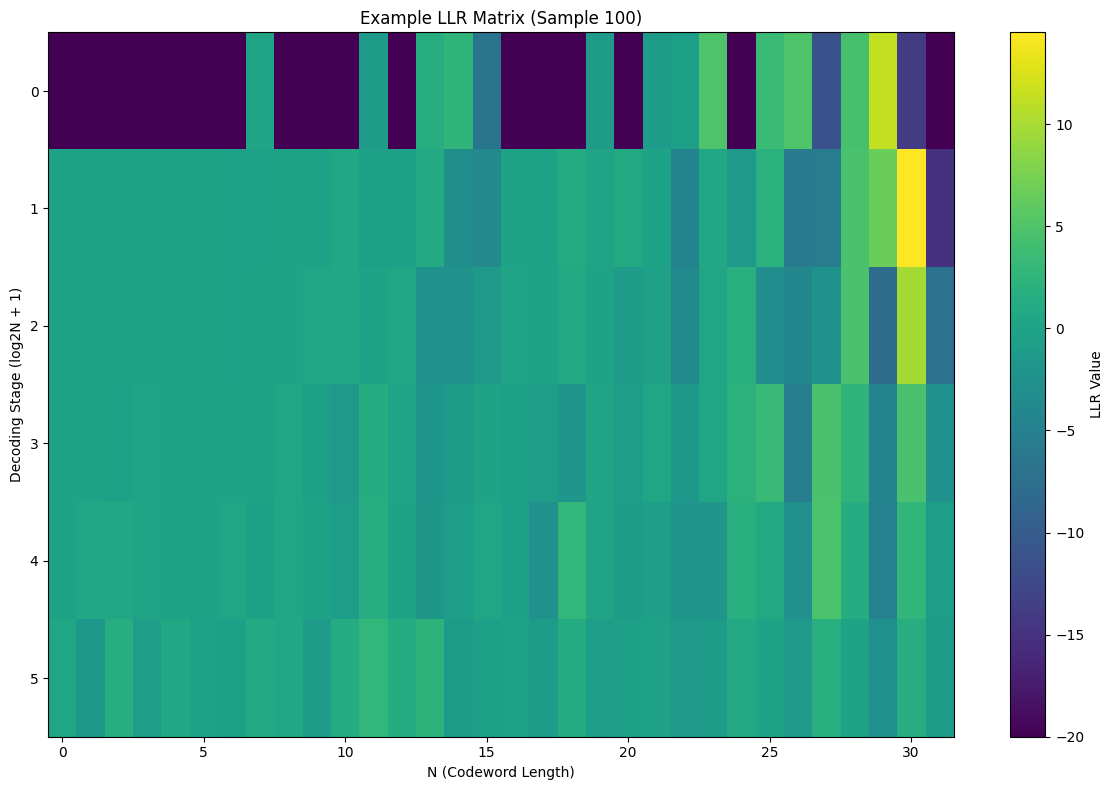

In [17]:
# Visualize an example LLR matrix
sample_idx = 100
sample = dataset[sample_idx]
print(sample)
visualize_llr_matrix(sample['llr_matrix'].numpy(), title=f"Example LLR Matrix (Sample {sample_idx})")

In [18]:
# Split dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [25]:
# Initialize the model
model = PolarLLRMatrixNet(n, K, hidden_channels).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
# Train the model
train_metrics = train_llr_matrix_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device
)

[Epoch 5] Train Loss: 0.3372, Val Loss: 0.2631
              Train BER: 0.1771, Val BER: 0.1366
              Train BLER: 0.7097, Val BLER: 0.3838


[Epoch 10] Train Loss: 0.2999, Val Loss: 0.2554
              Train BER: 0.1582, Val BER: 0.1273
              Train BLER: 0.6488, Val BLER: 0.3999


[Epoch 15] Train Loss: 0.2774, Val Loss: 0.2413
              Train BER: 0.1472, Val BER: 0.1253
              Train BLER: 0.6064, Val BLER: 0.3594


[Epoch 20] Train Loss: 0.2629, Val Loss: 0.2331
              Train BER: 0.1392, Val BER: 0.1227
              Train BLER: 0.5711, Val BLER: 0.3662


[Epoch 25] Train Loss: 0.2471, Val Loss: 0.2366
              Train BER: 0.1313, Val BER: 0.1225
              Train BLER: 0.5403, Val BLER: 0.3906


[Epoch 30] Train Loss: 0.2361, Val Loss: 0.2403
              Train BER: 0.1256, Val BER: 0.1202
              Train BLER: 0.5244, Val BLER: 0.3569


[Epoch 35] Train Loss: 0.2213, Val Loss: 0.2587
              Train BER: 0.1175, Val BER: 0.1185
              Train BLER: 0.4941, Val BLER: 0.3638


[Epoch 40] Train Loss: 0.2127, Val Loss: 0.2325
              Train BER: 0.1118, Val BER: 0.1181
              Train BLER: 0.4827, Val BLER: 0.3735


[Epoch 45] Train Loss: 0.2028, Val Loss: 0.2411
              Train BER: 0.1067, Val BER: 0.1146
              Train BLER: 0.4673, Val BLER: 0.3628


⏹️ Early stopping at epoch 47!
✅ Training complete. Best val loss: 0.2299 at epoch 27
📁 Logs saved to: training_logs/train_log_N_32_K_16_SNR_1.0.csv


In [27]:
len(train_metrics[0])

47

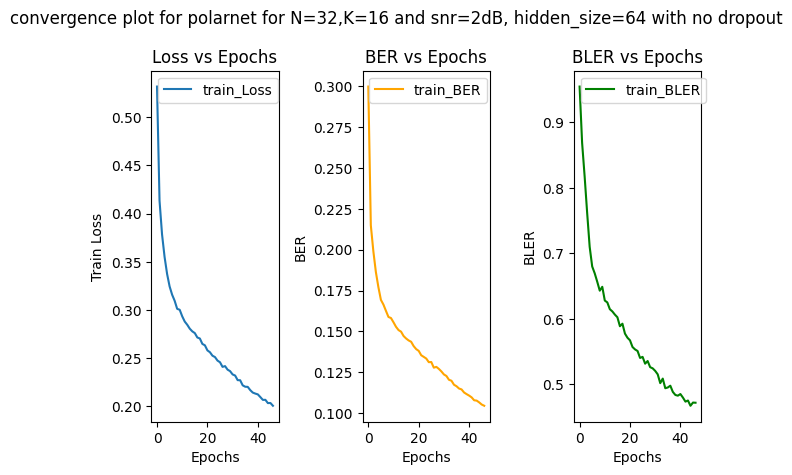

In [28]:
plt.suptitle('convergence plot for polarnet for N=32,K=16 and snr=2dB, hidden_size=64 with no dropout')
# Plot Loss vs Epochs
plt.subplot(1, 3, 1)
plt.plot(train_metrics[0], label='train_Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

# Plot BER vs Epochs
plt.subplot(1, 3, 2)
plt.plot(train_metrics[1], label='train_BER', color='orange')
plt.title('BER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()

# Plot BLER vs Epochs

plt.subplot(1, 3, 3)
plt.plot(train_metrics[2], label='train_BLER', color='green')
plt.title('BLER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BLER')
plt.legend()

plt.tight_layout()
plt.show()

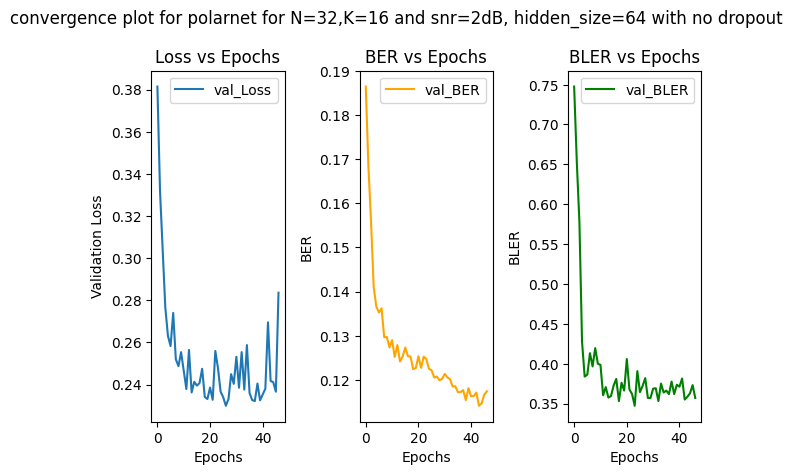

In [29]:
plt.suptitle('convergence plot for polarnet for N=32,K=16 and snr=2dB, hidden_size=64 with no dropout')
# Plot Loss vs Epochs
plt.subplot(1, 3, 1)
plt.plot(train_metrics[3], label='val_Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

# Plot BER vs Epochs
plt.subplot(1, 3, 2)
plt.plot(train_metrics[4], label='val_BER', color='orange')
plt.title('BER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()

# Plot BLER vs Epochs

plt.subplot(1, 3, 3)
plt.plot(train_metrics[5], label='val_BLER', color='green')
plt.title('BLER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BLER')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
model.load_state_dict(torch.load(r'/content/PolarNet/weights_llr_matrix/N_32_K_16_SNR_1.0_hidden_6144/epoch_27.pth'),strict=True)


<All keys matched successfully>

In [31]:
# Initialize PolarCode decoder
polar = PolarCode(n=5, K=16, rs=Reliability_Sequence, use_cuda=torch.cuda.is_available())

# Testing loop for PolarCode decoder
def test_polar_decoder(test_loader, snr):
    test_ber_total, test_bler_total = 0.0, 0.0
    count = 0
    num_batches_to_print = 5  # Print details for first N batches

    with torch.no_grad():
        print(f"Starting testing at SNR={snr}dB...")
        for batch_idx, test_batch in enumerate(test_loader):
            count += 1

            # Get batch data
            msg_bits = test_batch['msg_bits'].to(device)
            corrupted_codeword = test_batch['corrupted_codeword'].to(device)

            # Run through decoder
            final_llrs, decoded_bits, _ = polar.sc_decode_new(corrupted_codeword, snr=snr)

            # Convert decoded bits to same format as msg_bits (0/1)
            decoded_bits_binary = (decoded_bits < 0).float()  # Convert -1/1 to 0/1

            # Calculate metrics
            ber, bler = calculate_ber_bler(msg_bits, decoded_bits_binary)
            test_ber_total += ber
            test_bler_total += bler

            # Print sequences for debugging
            if batch_idx < num_batches_to_print:
                print(f"\nBatch {batch_idx + 1}")
                print(f"Original: {msg_bits[0].int().tolist()}")
                print(f"Decoded:  {decoded_bits_binary[0].int().tolist()}")
                print(f"BER: {ber:.4f}, BLER: {bler:.4f}")
                if torch.all(decoded_bits_binary[0].round() == msg_bits[0]):
                    print("✅ Correct")
                else:
                    print("❌ Errors")

    # Calculate final metrics
    test_avg_ber = test_ber_total / len(test_loader)
    test_avg_bler = test_bler_total / len(test_loader)

    print("\nFinal Results:")
    print(f"Average BER: {test_avg_ber:.6f}")
    print(f"Average BLER: {test_avg_bler:.6f}")
    print(f"Total batches tested: {count}")

    return test_avg_ber, test_avg_bler

# Run the test
test_ber, test_bler = test_polar_decoder(test_loader, snr=2.0)  # SNR in dB

Streaming output truncated to the last 5000 lines.
Output LLRs (non-zero count): 12254/12288
Output LLRs (non-zero count): 12254/12288
Output LLRs (non-zero count): 12254/12288
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 2048/12288
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 3072/12288
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 3584/12288
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 3840/12288
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 3944/12288
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 4008/12288
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4008/12288
Depth: 3, Bit position: 0
Input LLRs (non-zero count): 4008/12288
Depth: 2, Bit position: 0
Input LLRs (non-zero count): 4008/12288
Depth: 1, Bit position: 0
Input LLRs (non-zero count): 4008/12288
Depth: 5, Bit position: 0
Input LLRs (non-zero count): 4072/12288
Depth: 4, Bit position: 0
Input LLRs (non-zero count): 4072/12288
Depth: 3, Bit position: 0
Input